# Load dependencies

In [1]:
import os
import numpy as np
import pandas as pd
import xarray as xr
import cv2 as cv
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.backends.backend_pdf import PdfPages
import warnings
warnings.filterwarnings('ignore')
# import ray
import matplotlib as mpl
import io_dict_to_hdf5 as ioh5
from tqdm import tqdm
import scipy


### define functions for eye/head movement analysis

# remove duplicate saccades
def drop_repeat_sacc(eventT, onset=True, win=0.020):
    """For saccades spanning multiple camera
    frames, only keep one saccade time. Either first or last.

    If `onset`, keep the first in a sequence (i.e. the onset of
    the movement). otherwise, keep the final saccade in the sequence

    """
    duplicates = set([])
    for t in eventT:
        if onset:
            new = eventT[((eventT-t)<win) & ((eventT-t)>0)]
        else:
            new = eventT[((t-eventT)<win) & ((t-eventT)>0)]
        duplicates.update(list(new))
    out = np.sort(np.setdiff1d(eventT, np.array(list(duplicates)), assume_unique=True))
    return out

#remove saccades from around compensatory movements
def drop_sacc_near(thin, avoid, win=0.25):
    """
    `thin` is the list of saccade times to thin out
    `avoid` are the ones that `thin` is not allowed to be near

    if eliminating comp that fall near a gaze shift, `thin`
    should be compensatory event times
    
    """
    to_drop = np.array([c for c in thin for g in avoid if ((g>(c-win)) & (g<(c+win)))])
    thinned = np.delete(thin, np.isin(thin, to_drop))
    return thinned

def calc_PSTH(spikeT, eventT, bandwidth=10, resample_size=1, edgedrop=15, win=1000):
    """
    calcualtes for a single cell at a time

    bandwidth (msec)
    resample_size (msec)
    edgedrop (msec to drop at the start and end of the window so eliminate artifacts of filtering)
    win = 1000msec before and after
    """

    bandwidth = bandwidth / 1000
    resample_size = resample_size / 1000
    win = win / 1000
    edgedrop = edgedrop / 1000
    edgedrop_ind = int(edgedrop / resample_size)

    bins = np.arange(-win-edgedrop, win+edgedrop+resample_size, resample_size)

    # Timestamps of spikes (`sps`) relative to `eventT`
    sps = []
    for i, t in enumerate(eventT):
        sp = spikeT-t
        # Only keep spikes in this window
        sp = sp[(sp <= (win+edgedrop)) & (sp >= (-win-edgedrop))] 
        sps.extend(sp)
    sps = np.array(sps)

    kernel = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(sps[:, np.newaxis])
    density = kernel.score_samples(bins[:, np.newaxis])

    # Multiply by the # spikes to get spike count per point. Divide
    # by # events for rate/event.
    psth = np.exp(density) * (np.size(sps ) / np.size(eventT))

    # Drop padding at start & end to eliminate edge effects.
    psth = psth[edgedrop_ind:-edgedrop_ind]

    return psth

# Make gaze shift plots for midi video

### load data and get gaze shift times

In [2]:
group_file = r'C:\Users\nlab\Desktop\hffm_062022_gt.pickle' #hf/fm
og_df = pd.read_pickle(group_file)

time_pts = np.load(r'C:\Users\nlab\Downloads\trange_x.npy')

# remove inserted column if it exists
try:
    del og_df['level_0']
except:
    pass

numAni = len(np.unique(og_df['session'])) #get number of animals

### relabel clusters so that it's easier to sort them
og_df['gaze_label'] = og_df['movcluster']
og_df['gaze_label'] = og_df['gaze_label'].replace('biphasic','2_biphasic')
og_df['gaze_label'] = og_df['gaze_label'].replace('early','0_early')
og_df['gaze_label'] = og_df['gaze_label'].replace('late','1_late')
og_df['gaze_label'] = og_df['gaze_label'].replace('negative','3_negative')
og_df['gaze_label'] = og_df['gaze_label'].replace('unresponsive','4_unresponsive')
gaze_keys = np.unique(og_df['gaze_label'])

### take 0709 data specifically
df = og_df[(og_df['session'].str.contains('0709'))&(og_df['gaze_label']!='4_unresponsive')]
df.reset_index(inplace=True,drop=True)

df = df.sort_values(by=['FmLt_gazeshift_peakT'],axis=0,ascending=True)
df.reset_index(inplace=True,drop=True)

eyeT = df['FmLt_eyeT'].iloc[0][:-1]
dHead = df['FmLt_dHead'].iloc[0]
dGaze = df['FmLt_dGaze'].iloc[0]
dTheta = df['FmLt_dEye_dps'].iloc[0]
saccthresh = {
        'head_moved': 60,
        'gaze_stationary': 120,
        'gaze_moved': 240
    } # deg/sec

### get gaze shift times
gazeL = eyeT[(dHead > saccthresh['head_moved']) & (dGaze > saccthresh['gaze_moved'])]
gazeR = eyeT[(dHead < -saccthresh['head_moved']) & (dGaze < -saccthresh['gaze_moved'])]

compL = eyeT[(dHead > saccthresh['head_moved']) & (dGaze < saccthresh['gaze_stationary']) & (dGaze > -saccthresh['gaze_stationary'])]
compR = eyeT[(dHead < -saccthresh['head_moved']) & (dGaze > -saccthresh['gaze_stationary']) & (dGaze < saccthresh['gaze_stationary'])]

gaze = np.union1d(gazeL,gazeR)
comp = np.union1d(compL,compR)

gaze = drop_repeat_sacc(gaze, onset=True, win=0.020)
gazeL = drop_repeat_sacc(gazeL, onset=True, win=0.020)
gazeR = drop_repeat_sacc(gazeR, onset=True, win=0.020)

In [3]:
save_pdf = True
pdf_file = r'G:\.shortcut-targets-by-id\0B_PZYI0qdNesYXNncTM0VFZzUWc\Niell lab protocols information\Freely Moving Electrophysiology\example data\gaze shift data for matt\gaze_shift_rasters.pdf'
pp = PdfPages(pdf_file)


dT = 1
# max_gaze_ind = int(len(gaze)/20)
# Tmins = gaze[:max_gaze_ind]-dT #gaze shift times, 1 sec subtracted off for baseline plotting
### plot in 10s chunks instead of for each shift (@38s especially)
Tmins = np.array(gaze[:192])-dT
for t_ind,Tmin in enumerate(Tmins):
    if np.mod(len(Tmins),50)==0:
        print('doing %d of %d' % (t_ind,len(Tmins)))
    Tmax = Tmin + 2*dT
    dT_all = Tmax-Tmin
    cell_spikes = []
    for celln,spks in df['FmLt_spikeT'].iteritems():
        cell_spikes.append(spks[(spks>Tmin) &(spks<Tmax)])

    window_gazes = []
    for celln,spks in enumerate(gaze):
        var = spks[(spks>Tmin) &(spks<Tmax)]
        if len(var)>0:
            window_gazes.append(var)


    # wt=500
    fontsize=10
    # t=worldTmin + wt
    # tt = worldT[t].data
    # eye_interp_t = np.nanargmin(np.abs(eyeT-(tt)))
    # acc_interp_t = np.nanargmin(np.abs(accT2-(tt)))
    # cellT = np.linspace(Tmin,Tmax,worldTmax-worldTmin)
    # cell_t = np.nanargmin(np.abs(cellT-(tt)))

    inds = np.where((eyeT>Tmin)&(eyeT<Tmax))[0]

    fig, axs = plt.subplots(2,1,figsize=(3,6),dpi=300)
    ax = axs[0]
    ax.plot(eyeT[(eyeT>Tmin)&(eyeT<Tmax)],dTheta[(eyeT>Tmin)&(eyeT<Tmax)],'k',label='dTheta')
    ax.plot(eyeT[(eyeT>Tmin)&(eyeT<Tmax)],dHead[(eyeT>Tmin)&(eyeT<Tmax)],'r',label='dHead')
    ax.set_xlim(eyeT[inds[0]],eyeT[inds[-1]])
    ax.legend()


    ax = axs[1]
    ax.eventplot(cell_spikes,color='k',linelengths=.5)
    ax.set_xlabel('time (sec)',fontsize=fontsize)
    ax.set_ylabel('cell #',fontsize=fontsize)
    ax.set_xticks(np.arange(Tmin, Tmax+dT, dT))
    ax.set_xticklabels(np.arange(-dT, 2*dT, dT), fontsize=fontsize)
    ax.set_yticks([0,50,100])
    ax.set_yticklabels([0,50,100], fontsize=fontsize)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # ax.axvline(x=cellT[cell_t],c='b',lw=1)
    ax.set_xlim(Tmin,Tmax)
    ax.set_ylim(100,-1)
    ax.set_title('gaze %d t=%0.3f' % (t_ind,Tmin+dT))
    for g in window_gazes:
        ax.axvline(g,c='b',lw=1,ls=':')

    fig.tight_layout()
    if save_pdf:
        pp.savefig(fig,dpi=300)
        plt.close(fig)
if save_pdf:
    pp.close()

### save data for matt

In [4]:
### get spike times in 1d array, 'clusters' provides i.d. of the unit the spike belongs to (a la kilosort output)
matt_spikes = []
matt_clusters = []
for clust,spikes in enumerate(df['FmLt_spikeT']):
    for s,sp in enumerate(spikes):
        matt_spikes.append(sp)
        matt_clusters.append(clust)
# matt_spikes = matt_spikes - np.min(matt_spikes)
matt_spikes = np.array(matt_spikes)

order = np.argsort(matt_spikes)
matt_spikes = matt_spikes[order]

matt_clusters = np.array(matt_clusters).astype('int32')
matt_clusters = matt_clusters[order]

theta = df['FmLt_theta'].iloc[0]

### save as a .mat file
dict = {'spikes':matt_spikes,'clusters':matt_clusters,'gaze':gaze,'gazeL':gazeL,'gazeR':gazeR,'eyeT':eyeT,'dEye':dTheta,'dHead':dHead,'dGaze':dGaze,'theta':theta}
scipy.io.savemat(r'G:\.shortcut-targets-by-id\0B_PZYI0qdNesYXNncTM0VFZzUWc\Niell lab protocols information\Freely Moving Electrophysiology\example data\gaze shift data for matt\gaze_shift_data.mat',dict)

# Optic flow analysis

(0.0, 1.0)

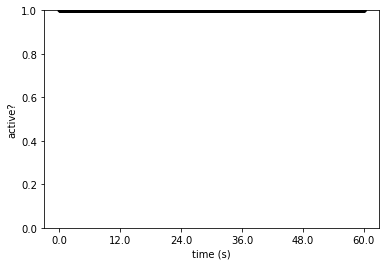

In [4]:
model_data_file = r'\\goeppert\nlab-nas\freely_moving_ephys\ephys_recordings\070921\J553RT\fm1\070921_J553RT_ModelData_dt025_rawWorldCam_2ds.h5'
data = ioh5.load(model_data_file)
wc_data = data['model_vis_sm_shift']
wc_data.shape

nan_frames = np.where(np.isnan(wc_data[:,0,0]))[0]
for fr in nan_frames:
    wc_data[fr,:,:] = wc_data[fr-1,:,:]

fps = 40
st=3*60*fps #input mins for start frame
tot_frames = 1*60*fps # num frames needed for 1 min movie at fps
good_idxs = np.ones(len(data['model_active']),dtype=bool) # frames when mouse is active
good_idxs[data['model_active']<.5] = False
good_idxs.astype('int')
plt.plot(good_idxs[st:st+tot_frames],'k.-')
plt.gca().set_xticks(np.arange(0,tot_frames+tot_frames/5,tot_frames/5))
plt.gca().set_xticklabels(np.arange(0,tot_frames/40+tot_frames/(5*40),tot_frames/(5*40)))
plt.ylabel('active?')
plt.xlabel('time (s)')
plt.ylim(0,1)

In [7]:
data['model_nsp'].shape

(108707, 128)

In [542]:
tot_frames/40

60.0

In [32]:
out_name = r'C:\Users\nlab\Desktop\worldStimTest.avi'
fps=40
frame_width=wc_data.shape[2]
frame_height=wc_data.shape[1]
out = cv.VideoWriter(out_name, cv.VideoWriter_fourcc('M','J','P','G'), fps,(frame_width,frame_height))

# #convert data into uint8
# wc_min = np.min(wc_data[:])
# wc_data_norm = (wc_data-wc_min)
# wc_max = np.max(wc_data_norm[:])
# wc_data_norm /= wc_max
# wc_data_norm *= 255
# wc_data_norm = wc_data_norm.astype('uint8')

#convert data into uint8
wc_std = np.std(wc_data[:])
wc_data_norm = (wc_data+wc_std)
wc_data_norm[:][np.where(wc_data_norm<0)]=0
wc_data_norm[:][np.where(wc_data_norm>wc_std)]=wc_std
wc_data_norm /= (wc_std*2)
wc_data_norm *= 255
wc_data_norm = wc_data_norm.astype('uint8')

for i in np.arange(st,st+tot_frames):
    frame = wc_data_norm[i,:,:]
    frame = cv.merge((frame,frame,frame))
    out.write(frame)
    if np.mod(i,100)==0:
        print('wrote frame %d' % i)
    # if cv.waitKey(1) & 0xFF == ord('q'):
    #     break
out.release()


wrote frame 20000
wrote frame 20100
wrote frame 20200
wrote frame 20300
wrote frame 20400
wrote frame 20500
wrote frame 20600
wrote frame 20700
wrote frame 20800
wrote frame 20900
wrote frame 21000
wrote frame 21100
wrote frame 21200
wrote frame 21300
wrote frame 21400
wrote frame 21500
wrote frame 21600
wrote frame 21700
wrote frame 21800
wrote frame 21900
wrote frame 22000
wrote frame 22100
wrote frame 22200
wrote frame 22300


(array([8.12002000e+05, 2.13111050e+07, 1.00127565e+08, 2.60355234e+08,
        1.24334261e+08, 8.37588800e+06, 5.98180700e+06, 4.92709000e+05,
        2.93700000e+03, 9.20000000e+01]),
 array([-3.7924123 , -2.7238095 , -1.6552069 , -0.5866042 ,  0.48199853,
         1.5506012 ,  2.619204  ,  3.6878066 ,  4.756409  ,  5.825012  ,
         6.893615  ], dtype=float32),
 <BarContainer object of 10 artists>)

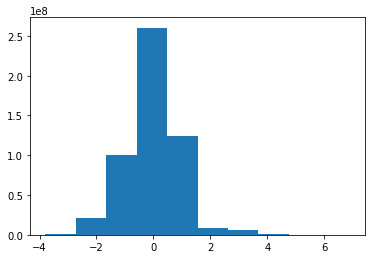

In [26]:
plt.hist(wc_data.flatten())

In [27]:
wc_std

3.6063625812530518

In [74]:
out_name = r'C:\Users\nlab\Desktop\worldStimTest.avi'
fps=40
frame_width=wc_data.shape[2]
frame_height=wc_data.shape[1]
out = cv.VideoWriter(out_name, cv.VideoWriter_fourcc('M','J','P','G'), fps,(frame_width,frame_height))

#convert data into uint8
wc_min = np.min(np.min(np.min(wc_data)))
wc_data_norm = (wc_data-wc_min)
wc_max = np.max(np.max(np.max(wc_data_norm)))
wc_data_norm /= wc_max
wc_data_norm *= 255
wc_data_norm = wc_data_norm.astype('uint8')
wc_data_norm[1,:,:]

for i in np.arange(st,st+tot_frames):
    frame = wc_data_norm[i,:,:]
    out.write(frame)
    print('wrote frame %d' % i)
    # if cv.waitKey(1) & 0xFF == ord('q'):
    #     break
out.release()

wrote frame 20000
wrote frame 20001
wrote frame 20002
wrote frame 20003
wrote frame 20004
wrote frame 20005
wrote frame 20006
wrote frame 20007
wrote frame 20008
wrote frame 20009
wrote frame 20010
wrote frame 20011
wrote frame 20012
wrote frame 20013
wrote frame 20014
wrote frame 20015
wrote frame 20016
wrote frame 20017
wrote frame 20018
wrote frame 20019
wrote frame 20020
wrote frame 20021
wrote frame 20022
wrote frame 20023
wrote frame 20024
wrote frame 20025
wrote frame 20026
wrote frame 20027
wrote frame 20028
wrote frame 20029
wrote frame 20030
wrote frame 20031
wrote frame 20032
wrote frame 20033
wrote frame 20034
wrote frame 20035
wrote frame 20036
wrote frame 20037
wrote frame 20038
wrote frame 20039
wrote frame 20040
wrote frame 20041
wrote frame 20042
wrote frame 20043
wrote frame 20044
wrote frame 20045
wrote frame 20046
wrote frame 20047
wrote frame 20048
wrote frame 20049
wrote frame 20050
wrote frame 20051
wrote frame 20052
wrote frame 20053
wrote frame 20054
wrote fram

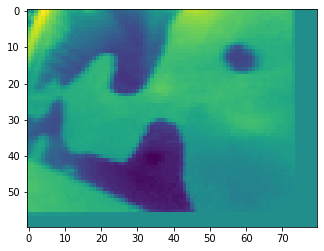

In [73]:
plt.imshow(wc_data_norm[20000,:,:])

In [70]:
frame = wc_data[1,:,:].T
frame.shape


(80, 60)

In [47]:
print(np.sum(np.isnan(wc_data[st:st+tot_frames,0,0])),tot_frames)


1714 24000


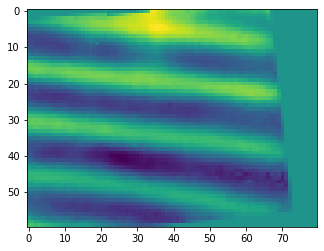

In [34]:
plt.imshow(wc_data[1,:,:])#.astype('uint8'))

In [ ]:
# model data .h5 file
model_data_file = '/home/niell_lab/Desktop/optic_flow_test/ModelData_dt025_rawWorldCam.h5'
# ephys .h5 file
# this is only needed if you want to compare topdown movement states
# if topdown data isn't in the ephys .h5 file, set it to None
ephys_path = '/home/niell_lab/Desktop/optic_flow_test/070921_J553RT_control_Rig2_fm1_ephys_props.h5'
# save path for the optic flow npz
save_name = '/home/niell_lab/Desktop/optic_flow_test/070921_J553RT_fm1_optic_flow.npz'

# Load in worldcam/ephys data and calculate optic flow (currently takes about 3 mins 45 sec)

In [4]:
data = ioh5.load(model_data_file)

### set the lags for STAs (in frames, currently 25ms bins)
lag_list = [-2,-1,0,1,2]

### get shifted worldcam data
wc_data = data['mod_vid_sm_shift']

### calculate optic flow for the entire video
win=5 #window for optic flow calculation (# frames)
fr = wc_data.shape[0]-2 # total number of frames in video (-1 since we're taking the difference between consecutive and -1 for first WC frame being nans)
h = wc_data.shape[1] # image height
w = wc_data.shape[2] # image width
flow_data = np.zeros((fr,h,w,2)) # initialize optic flow array flow_data[frame#,x,y,u/v]

print('calculating optic flow')
### loop over all frames to get optic flow, populate array
for f in tqdm(np.arange(1,fr,1)):
    flow = cv.calcOpticalFlowFarneback(wc_data[f,:,:],wc_data[f+1,:,:], None, 0.5, 3, win, 3, 5, 1.2, 0)
    flow_data[f,:,:,0] = flow[:,:,0]
    flow_data[f,:,:,1] = flow[:,:,1]

##### under construction
### filter on frames when animal is moving forward
# topdown_file = r'C:\Users\nlab\Downloads\070921_J553RT_fm1_topdown.npz'
# topdown_props = np.load(topdown_file)
# good_idxs = topdown_props['running_forward']

##### Elliott's code: Find 'good' timepoints when mouse is active #####
nan_idxs = []
for key in data.keys():
    nan_idxs.append(np.where(np.isnan(data[key]))[0])
good_idxs = np.ones(len(data['model_active']),dtype=bool)
good_idxs[data['model_active']<.5] = False
good_idxs[np.unique(np.hstack(nan_idxs))] = False

good_idxs[0] = False # first worldcam frame is nan
good_idxs[1] = False # first flow frame is nan

full_recording = np.ones(len(data['model_active']), dtype=bool)

if ephys_path is not None:
    ephys_df = pd.read_hdf(ephys_path)
    activity_state_bools = [full_recording, good_idxs, ~good_idxs,
                            list(ephys_df['fm1_top_is_forward'].iloc[0].astype(bool)),
                            list(ephys_df['fm1_top_is_backward'].iloc[0].astype(bool)),
                            list(ephys_df['fm1_top_is_fine_motion'].iloc[0].astype(bool)),
                            list(ephys_df['fm1_top_is_immobile'].iloc[0].astype(bool))]
    activity_state_names = ['full', 'active_gyro', 'inactive_gyro', 'running_forward', 'running_backward', 'fine_motion', 'immobile']
    
elif ephys_path is None:
    activity_state_bools = [full_recording, good_idxs, ~good_idxs]
    activity_state_names = ['full','active_gyro','inactive_gyro']
    
crop_pix = 10 # pixels to crop on each side of the image
flow_amp_dict = {}
flow_vec_dict = {}
for state_num in range(len(activity_state_names)):
    activity_state_bool = activity_state_bools[state_num]
    activity_state_name = activity_state_names[state_num]
    
    print(activity_state_name)
    
    # filter for current def of activity
    # also need to crop worldcam to get rid of shifter artifacts
    raw_nsp = data['model_nsp'].copy()
    state_nsp = raw_nsp[activity_state_bool]
    
    raw_wc_data = wc_data.copy()
    state_wc = raw_wc_data[activity_state_bool, crop_pix:-crop_pix, crop_pix:-crop_pix]
    
    raw_flow_data = flow_data.copy()
    raw_flow_data = np.vstack((np.zeros((2,raw_flow_data.shape[1],raw_flow_data.shape[2],raw_flow_data.shape[3])),raw_flow_data))
    state_flow = raw_flow_data[activity_state_bool, crop_pix:-crop_pix, crop_pix:-crop_pix]

    num_cells = np.size(state_nsp,1)
    
    # optic flow amplitude
    flow_amp = np.sqrt(state_flow[:,:,:,0]**2 + state_flow[:,:,:,1]**2) # optic flow amp
    flow_amp_mn = np.mean(flow_amp, axis=0) # get mean
    flow_amp_std = np.std(flow_amp, axis=0) # get std
    flow_amp_mnsub = flow_amp.copy() # copy for z-scoring
    flow_amp_mnsub -= flow_amp_mn # subtract mean from flow data
    flow_amp_mnsub /= flow_amp_std # divide by standard deviation
    rolled_vid = np.hstack([np.roll(flow_amp_mnsub, nframes, axis=0) for nframes in lag_list]) # incorporate lags
    model_vid = rolled_vid.reshape(flow_amp_mnsub.shape[0],-1) # reshape for sta calculation
    sta = (model_vid.T @ state_nsp)/np.sum(state_nsp,0,keepdims=True) # get sta
    flow_amp_sta = sta.T.reshape((num_cells,len(lag_list)) + flow_amp_mnsub.shape[1:]) #reshape flow amp sta into [unit,lag,x,y]

    # optic flow vector
    flow_mn = np.mean(state_flow, axis=0) # calculate flow mean
    flow_std = np.std(state_flow, axis=0) # calculate flow std
    flow_data_mnsub = state_flow.copy() # copy flow data to be z-scored
    flow_data_mnsub -= flow_mn # subtract mean from flow data
    flow_data_mnsub /= flow_std # divide by standard deviation
    rolled_vid = np.hstack([np.roll(flow_data_mnsub, nframes, axis=0) for nframes in lag_list]) # incorporate lags
    model_vid = rolled_vid.reshape(flow_data_mnsub.shape[0],-1) # reshape flow data for sta
    sta = (model_vid.T @ state_nsp)/np.sum(state_nsp,0,keepdims=True) # calculate flow sta
    flow_vector_sta = sta.T.reshape((num_cells,len(lag_list)) + flow_data_mnsub.shape[1:]) # reshape flow sta into [unit,lag,x,y,U/V]
    
    flow_amp_dict[activity_state_name] = flow_amp_sta
    flow_vec_dict[activity_state_name] = flow_vector_sta
    
print('saving')
if ephys_path is not None:
    np.savez(file=save_name,
             full_vec=flow_vec_dict['full'], full_amp=flow_amp_dict['full'],
             active_gyro_vec=flow_vec_dict['active_gyro'], active_gyro_amp=flow_amp_dict['active_gyro'],
             inactive_gyro_vec=flow_vec_dict['inactive_gyro'], inactive_gyro_amp=flow_amp_dict['inactive_gyro'],
             running_forward_vec=flow_vec_dict['running_forward'], running_forward_amp=flow_amp_dict['running_forward'],
             running_backward_vec=flow_vec_dict['running_backward'], running_backward_amp=flow_amp_dict['running_backward'],
             fine_motion_vec=flow_vec_dict['fine_motion'], fine_motion_amp=flow_amp_dict['fine_motion'],
             immobile_vec=flow_vec_dict['immobile'], immobile_amp=flow_amp_dict['immobile'])

elif ephys_path is None:
    np.savez(file=save_name,
             full_vec=flow_vec_dict['full'], full_amp=flow_amp_dict['full'],
             active_gyro_vec=flow_vec_dict['active_gyro'], active_gyro_amp=flow_amp_dict['active_gyro'],
             inactive_gyro_vec=flow_vec_dict['inactive_gyro'], inactive_gyro_amp=flow_amp_dict['inactive_gyro'])

calculating optic flow


100%|██████████████████████████████████████████████████████████████████████████████| 108704/108704 [01:15<00:00, 1445.43it/s]


# Plot optic flow RFs (currently takes about 40 sec)

In [5]:
### calculate avg firing rates for plotting
avg_rates = np.round((1/0.025)*np.sum(model_nsp,axis=0)/model_nsp.shape[0],1)

### create a meshgrid to plot flow vectors downsampled
h = flow_data.shape[1]
w = flow_data.shape[2]
X,Y = np.meshgrid(np.arange(0,w),np.arange(0,h))

nx=5 #binning for plotting flow vectors

vmin=-0.25 #scaling for wn and flow amp STAs
vmax=0.25

### make PDF to plot results
pdf_file = r'T:/freely_moving_ephys/%s_flowSTAs_bin%dX_win%d_zscoreflow_movingforward.pdf' % (os.path.split(model_data_file)[-1][:-4],nx,win)
pp = PdfPages(pdf_file)

### plot the mean worldcam image with mean flow vector overlaid
fig, axs = plt.subplots(1,2,figsize=(10,5))
ax = axs[0]
ax.imshow(np.mean(wc_data,axis=0),cmap='gray')
sta = flow_mn
U = sta[:,:,0]
V = sta[:,:,1]
scale = 10*np.max(np.sqrt(U**2 + V**2))
ax.quiver(X[::nx,::nx],Y[::nx,::nx],U[::nx,::nx],-V[::nx,::nx],scale=scale)
ax.set_title('mean worldcam/optic flow')
ax.axis('off')
### plot the std worldcam image with std flow vector overlaid
ax = axs[1]
ax.imshow(np.std(wc_data,axis=0),cmap='gray')
sta = flow_std
U = sta[:,:,0]
V = sta[:,:,1]
scale = 10*np.max(np.sqrt(U**2 + V**2))
ax.quiver(X[::nx,::nx],Y[::nx,::nx],U[::nx,::nx],-V[::nx,::nx],scale=scale)
ax.set_title('std worldcam/optic flow')
ax.axis('off')
fig.tight_layout()
### save the figure
pp.savefig(fig)
plt.close(fig)

### calculate a scale for plotting optic flow vectors by taking max of flow across units/lags
scale = np.zeros((len(goodcells),len(lag_list)))
for l,lag in enumerate(lag_list):
    for c,ind in enumerate(goodcells):
        sta = flow_sta[c,l,:,:,:]
        U = sta[:,:,0].flatten()
        V = sta[:,:,1].flatten()
        scale[c,l] = np.max(np.sqrt(U**2 + V**2))
scale = np.max(scale.flatten())

### plot the optic flow vectors across lags for each cell in a separate figure
for c, (ind,spikes) in enumerate(zip(goodcells,avg_rates)):
    fig, axs = plt.subplots(2,len(lag_list)+1,figsize=(3*(len(lag_list)+1),3))
    
    ### turn off axes on blank panel
    ax = axs[1,0]
    ax.axis('off')

    ax = axs[0,0]
    ### plot the cell's white noise RF first
    ax.imshow(wn_sta[c,2,:,:],vmin=vmin,vmax=vmax,cmap='jet') #plot white noise sta
    ax.set_title('unit %d(%d) %0.1fHz avg' % (c,ind,spikes),fontsize=10)
    ax.axis('off')
    ax.axis('equal')
    
    ### cycle through lags and plot flow vectors and amps
    for l,lag in enumerate(lag_list):
        ax = axs[0,l+1]
        sta = flow_sta[c,l,:,:,:]
        U = sta[:,:,0]
        V = sta[:,:,1]
        ax.quiver(X[::nx,::nx],-Y[::nx,::nx],U[::nx,::nx],-V[::nx,::nx],scale=scale)
        ax.axis('off')
        ax.axis('equal')
        ax.set_title('lag %dms' % (lag*25),fontsize=10)

        ax = axs[1,l+1]
        sta = flow_amp_sta[c,l,:,:]
        ax.imshow(sta,vmin=vmin,vmax=vmax,cmap='jet') #plot white noise sta
        ax.axis('off')
        ax.axis('equal')

    ### add flow vectors to white noise RF plot
    ax = axs[0,0]
    sta = flow_sta[c,np.where(np.array(lag_list)==0)[0][0],:,:,:]
    U = sta[:,:,0]
    V = sta[:,:,1]
    ax.quiver(X[::nx,::nx],Y[::nx,::nx],U[::nx,::nx],-V[::nx,::nx],scale=scale)
    fig.tight_layout()
    
    ### save the figure to pdf
    pp.savefig(fig)
    plt.close(fig)

### close the pdf
pp.close()

In [17]:
np.where(np.isnan(topdown_props['top_speed']))[0].shape

(5191,)

## Exploring flow properties

0.0011137878441598468


Text(0.5, 1.0, 'mean of flow data')

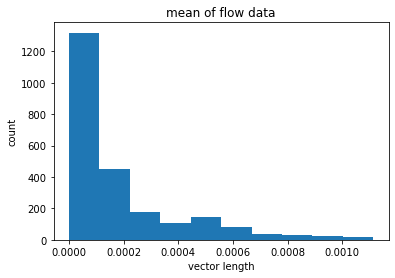

In [65]:
### histogram of mean vector lengths
sta = np.nanmean(flow_data,axis=0)
U = sta[:,:,0][:]
V = sta[:,:,1][:]
plt.hist(np.reshape(np.sqrt(U**2 + V**2),-1))
plt.xlabel('vector length')
plt.ylabel('count')
plt.title('mean of flow data')

Text(0.5, 1.0, 'std of flow data')

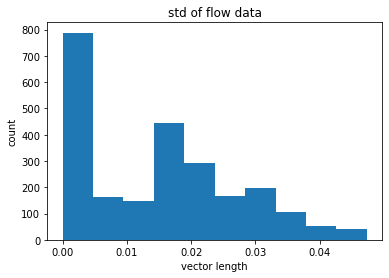

In [68]:
### histogram of std vector lengths
sta = np.nanstd(flow_data,axis=0)
U = sta[:,:,0][:]
V = sta[:,:,1][:]

plt.hist(np.reshape(np.sqrt(U**2 + V**2),-1))
plt.xlabel('vector length')
plt.ylabel('count')
plt.title('std of flow data')

Text(0.5, 1.0, 'mean world image, mean flow vectors, std as ellipses')

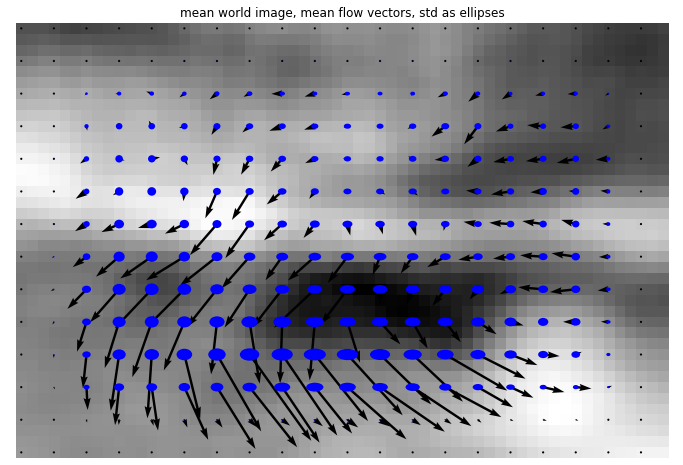

In [119]:
### plot the std as a set of ellipses, where width is proportional to u and height to v
fig, ax = plt.subplots(1,1,figsize=(12,8))
ax.imshow(np.mean(wc_data,axis=0),cmap='gray')
ells=[]
# scale = 5*np.max(np.sqrt(U**2 + V**2))
nx=3
scale = 50
sta = np.nanstd(flow_data,axis=0)
U = sta[:,:,0]
V = sta[:,:,1]
for x,y,u,v in zip(X[::nx,::nx].flatten(),Y[::nx,::nx].flatten(),U[::nx,::nx].flatten(),V[::nx,::nx].flatten()):
    ells.append(Ellipse(xy=(x,y),height=v*scale,width=u*scale))
for e in ells:
    ax.add_artist(e)
    e.set_clip_box(ax.bbox)
    e.set_alpha(1)
    e.set_facecolor('b')

sta = flow_mn
U = sta[:,:,0]
V = sta[:,:,1]
scale = 6*np.max(np.sqrt(U**2 + V**2))
ax.quiver(X[::nx,::nx],Y[::nx,::nx],U[::nx,::nx],-V[::nx,::nx],scale=scale)

ax.axis('off')
ax.axis('equal')
ax.set_title('mean world image, mean flow vectors, std as ellipses')

# Make a video clip of optic flow overlaid on shifted video

In [37]:
### 
ray.init(ignore_reinit_error=True)
t=100
nx = 5
scale = 0.25
vm = 5

@ray.remote
def plot_optic_flow_movie(wc_data,flow_data,flow_amp,t,nx,scale):
    fig, axs = plt.subplots(1,2,figsize=(10,3))

    ax = axs[0]
    ax.imshow(wc_data[t,:,:],cmap='gray')
    ax.set_title('shifter network-corrected image w/optic flow vectors',fontsize=8)
    ax.axis('off')
    ax.axis('equal')

    # ax = axs[1]
    X,Y = np.meshgrid(np.arange(0,wc_data.shape[2]),np.arange(0,wc_data.shape[1]))
    U = flow_data[t,:,:,0]
    V = flow_data[t,:,:,1]
    ax.quiver(X[::nx,::nx],Y[::nx,::nx],U[::nx,::nx],-V[::nx,::nx],scale=scale,color='r')
    # ax.axis('off')
    # ax.axis('equal')

    ax = axs[1]
    ax.imshow(flow_amp[t,:,:],vmin=-vm,vmax=vm,cmap='jet')
    ax.set_title('pixel-wise optic flow amplitude',fontsize=8)
    ax.axis('off')
    ax.axis('equal')

    fig.tight_layout()

    width, height = fig.get_size_inches() * fig.get_dpi()
    fig.canvas.draw()       # draw the canvas, cache the renderer
    images = np.frombuffer(fig.canvas.tostring_rgb(),
                        dtype='uint8').reshape(int(height), int(width), 3)
    
    plt.close(fig)
    
    return images

mpl.use('agg')

# start = time.time()
##### initialize time points for animation and progressbar #####
st_frame = 10000
t = st_frame
dt = 10*50 #sec * fps
time_range = np.arange(t,t+dt)
# num_ticks = np.size(time_range)
# pb = ProgressBar(num_ticks)
# actor = pb.actor

##### Put large arrays into shared memory #####
time_range_r = ray.put(time_range)
wc_data_r = ray.put(wc_data)
flow_data_r = ray.put(flow_data)
flow_amp_r = ray.put(flow_amp_mnsub)

##### Loop over parameters appending process ids #####
result_ids = []
for t in time_range:
    result_ids.append(plot_optic_flow_movie.remote(wc_data_r,flow_data_r,flow_amp_r,t,nx,scale))

##### pring progressbar and get results #####
# pb.print_until_done()
results_p = ray.get(result_ids)
images = np.stack([results_p[i] for i in range(len(results_p))])

##### Make video with opencv #####
aniname = 'optic_flow_test_stfr%d.mp4' % st_frame
vid_name = r'T:/freely_moving_ephys/' + aniname
frame_dt = 0.025
t_down = 4
FPS = int(1/(frame_dt*t_down))
out = cv.VideoWriter(vid_name, cv.VideoWriter_fourcc(*'mp4v'), FPS, (images.shape[-2], images.shape[-3]))

for fm in range(images.shape[0]):
    out.write(cv.cvtColor(images[fm], cv.COLOR_BGR2RGB))
out.release()
# print('Making Animation {}: {}'.format(aniname, time.time()-start))
# del results_p, time_range_r, model_vid_sm_r, model_gz_r, model_th_r, model_phi_r, pb
# gc.collect()


2021-12-07 21:49:01,039	INFO worker.py:833 -- Calling ray.init() again after it has already been called.


# Make PDF of flow

In [174]:
### plot some example flow data in a pdf

nrows = 3 # to show raw, difference, and optic flow
ncols = 10 # number of example frames to plot
fig_scale=3 # how big to blow up the figure

# st_frame = 1000 #animal moves a bit
st_frame = 10000 #monitor view

nx=5 #downsample factor
scale=0.25
win=15

### initialize the figure
fig, axs = plt.subplots(nrows,ncols,figsize=(ncols*fig_scale,nrows*fig_scale))

### initialize the pdf
pdf_file = r'T:/freely_moving_ephys/%s_frame%d_bin%dX_win%d_scale%0.2f.pdf' % (os.path.split(vid_file)[-1][:-4],st_frame,nx,win,scale)
pp = PdfPages(pdf_file)

### loop through example frames, get flow, and plot everything
for f,fr in enumerate(np.arange(st_frame,st_frame+ncols,1)):

    prvs = wc_data[fr,:,:] # current frame
    next = wc_data[fr+1,:,:] # next frame

    w = prvs.shape[0]
    h = prvs.shape[1]
    X,Y = np.meshgrid(np.arange(0,h),np.arange(0,w))

    flow = cv.calcOpticalFlowFarneback(prvs,next, None, 0.5, 3, win, 3, 5, 1.2, 0) #(prvs,next, None, 0.5, 3, 3, 15, 5, 1.2, 0)
    # mag, ang = cv.cartToPolar(flow[...,0], flow[...,1])

    ### plot raw frame
    ax = axs[0,f]
    im = ax.imshow(prvs,cmap='gray',vmin=-2.5,vmax=2.5)
    ax.axis('off')

    ### plot raw difference
    ax = axs[1,f]
    im2 = ax.imshow(next-prvs,cmap='jet',vmin=-2.5,vmax=2.5)
    ax.axis('off')

    ### plot optic flow
    ax = axs[2,f]
    U = flow[:,:,0]
    V = flow[:,:,1]
    ax.quiver(X[::nx,::nx],Y[::nx,::nx],U[::nx,::nx],-V[::nx,::nx],scale=scale)
    ax.axis('off')

### make colorbar for raw data
ax = axs[0,f]   
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)

### make colorbar for raw difference
ax = axs[1,f]   
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im2, cax=cax)

### save figure to pdf and close both
pp.savefig(fig)
plt.close(fig)
pp.close()

print('finished making PDF!')

finished making PDF!


# Group eye movement analysis

In [38]:
### dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 12})
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import pylab
import warnings
warnings.filterwarnings('ignore')

### functions

def xy_axis(ax):
    
    ### Removes the top and right bounding axes that are plotted by default in matplotlib
    
    ### INPUTS
    ### ax: axis object (e.g. from fig,ax = plt.subplots(1,1))
    
    ### OUTPUTS
    ### ax: the same axis w/top and right lines removed
    
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')

    return ax

def zero_crossing(vec):
    ### input vector vec, returns point that crosses zero (float, not index in case there is no zero) 
    if (np.min(vec)<0)&(np.max(vec)>0):
        if len(np.where(vec==0)[0])==1:
            zero_pt = np.where(vec==0)[0]
        elif len(np.where(vec==0)[0])==0:
            zero_pt = np.argmin(np.abs(vec))+0.5
        return zero_pt
    else:
        raise ValueError('Array does not cross zero')



print('finished loading dependencies')

finished loading dependencies


## load either hf/fm or fmlt/fmdk

In [ ]:
group_file = r'C:\Users\nlab\Desktop\hffm_062022_gt.pickle' #hf/fm
og_df = pd.read_pickle(group_file)

time_pts = np.load(r'C:\Users\nlab\Downloads\trange_x.npy')

# remove inserted column if it exists
try:
    del og_df['level_0']
except:
    pass

numAni = len(np.unique(og_df['session'])) #get number of animals

### relabel clusters so that it's easier to sort them
og_df['gaze_label'] = og_df['movcluster']
og_df['gaze_label'] = og_df['gaze_label'].replace('biphasic','2_biphasic')
og_df['gaze_label'] = og_df['gaze_label'].replace('early','0_early')
og_df['gaze_label'] = og_df['gaze_label'].replace('late','1_late')
og_df['gaze_label'] = og_df['gaze_label'].replace('negative','3_negative')
og_df['gaze_label'] = og_df['gaze_label'].replace('unresponsive','4_unresponsive')
gaze_keys = np.unique(og_df['gaze_label'])

## run this for hf/fm

In [2]:
raw_psth_keys = ['FmLt_rightsacc_avg_gaze_shift_dHead','FmLt_leftsacc_avg_gaze_shift_dHead']
df = og_df.copy()
gaze_pref_200ms_win_psth, gaze_nonpref_200ms_win_psth, gaze_pref_200ms_win_peak, gaze_nonpref_200ms_win_peak, gaze_pref_200ms_win_peakind, gaze_nonpref_200ms_win_peakind = ([] for i in range(6))

for index,row in df.iterrows():
    Rtrace = row[raw_psth_keys[0]]
    trace = Rtrace-np.mean(Rtrace[baseline[0]:baseline[1]]) #removed np.abs
    ev = trace[evoked[0]:evoked[1]]
    Rgaze_peak = ev.max()
    Rgaze_peak_ind = ev.argmax()+evoked[0]

    Ltrace = row[raw_psth_keys[1]]
    trace = Ltrace-np.mean(Ltrace[baseline[0]:baseline[1]]) #removed np.abs
    ev = trace[evoked[0]:evoked[1]]
    Lgaze_peak = ev.max()
    Lgaze_peak_ind = ev.argmax()+evoked[0]

    if Rgaze_peak>Lgaze_peak:
        gaze_pref_200ms_win_psth.append(Rtrace)
        gaze_nonpref_200ms_win_psth.append(Ltrace)
        gaze_pref_200ms_win_peak.append(Rgaze_peak)
        gaze_nonpref_200ms_win_peak.append(Lgaze_peak)
        gaze_pref_200ms_win_peakind.append(Rgaze_peak_ind)
        gaze_nonpref_200ms_win_peakind.append(Lgaze_peak_ind)
    else:
        gaze_pref_200ms_win_psth.append(Ltrace)
        gaze_nonpref_200ms_win_psth.append(Rtrace)
        gaze_pref_200ms_win_peak.append(Lgaze_peak)
        gaze_nonpref_200ms_win_peak.append(Rgaze_peak)
        gaze_pref_200ms_win_peakind.append(Lgaze_peak_ind)
        gaze_nonpref_200ms_win_peakind.append(Rgaze_peak_ind)

df['gaze_pref_200ms_win_psth'] = gaze_pref_200ms_win_psth
df['gaze_nonpref_200ms_win_psth'] = gaze_nonpref_200ms_win_psth
df['gaze_pref_200ms_win_peak'] = gaze_pref_200ms_win_peak
df['gaze_nonpref_200ms_win_peak'] = gaze_nonpref_200ms_win_peak
df['gaze_pref_200ms_win_peakind'] = gaze_pref_200ms_win_peakind
df['gaze_nonpref_200ms_win_peakind'] = gaze_nonpref_200ms_win_peakind

# # psth_keys = ['FmLt_rightsacc_avg_gaze_shift_dHead','FmLt_leftsacc_avg_gaze_shift_dHead']
# psth_keys = ['gaze_pref_200ms_win_psth','gaze_nonpref_200ms_win_psth','Rc_psth']
# gaze_psth = np.zeros((len(psth_keys),len(df),len(df[psth_keys[0]].iloc[0])))
# for pnp,psth_key in enumerate(psth_keys[:2]):
#     for i,item in enumerate(df[psth_key]):
#         gaze_psth[pnp,i,:] = (item-np.mean(item[baseline[0]:baseline[1]]))/np.max(item) #subtract off min here instead of baseline, sort

# #redo pca and kmeans
# pref = gaze_psth[0,:,baseline[0]:evoked[1]]
# npref = gaze_psth[1,:,baseline[0]:evoked[1]]
# pca_input = np.hstack((pref,npref))
# pca_input.shape

# n_k = 10
# pca = PCA(n_components=n_k)
# reduced_data = pca.fit_transform(pca_input)
# kmeans = KMeans(init='k-means++', n_clusters=n_k, n_init=100) #maybe
# cluster_data = kmeans.fit_transform(reduced_data)

# fig,axs = plt.subplots(2,3,figsize=(12,8))
# axs = axs.ravel()
# for k in range(n_k):
#     ax = axs[k]
#     grp_psth = pca_input[np.where(kmeans.labels_==k)[0],:]
#     for p in grp_psth:
#         ax.plot(p,linewidth=0.5)
#     grp_trace = np.mean(grp_psth,axis=0)
#     ax.plot(grp_trace,'k',linewidth=2,label=str(k))
#     ax.set_title('cluster %d' % k)
#     ax.set_ylim(-1,1)


NameError: name 'og_df' is not defined

In [21]:
# df['gaze_label'] = kmeans.labels_
# df['gaze_label'] = df['gaze_label'].replace(0,'4_unrespGaze')
# df['gaze_label'] = df['gaze_label'].replace(1,'1_late')
# df['gaze_label'] = df['gaze_label'].replace(2,'2_biphasic')
# df['gaze_label'] = df['gaze_label'].replace(3,'3_negative')
# df['gaze_label'] = df['gaze_label'].replace(4,'0_early')
# gaze_keys = np.unique(df['gaze_label'])

# ### sort the df by something
# # df = df.sort_values('gaze_label') #sort by cluster
# # df = df.sort_values('tf_pref') #sort by tf preference
# unresp = df[df['gaze_label']=='4_unrespGaze'] #find unrespGaze units
# unresp.reset_index(inplace=True,drop=True)
# df = df[df['gaze_label']!='4_unrespGaze'] #remove unrespGaze units
# df.reset_index(inplace=True,drop=True)
# df = df.sort_values('gaze_pref_200ms_win_peakind')
# # df = pd.concat([df,unresp],ignore_index=True)
# # df.reset_index(inplace=True,drop=True)

In [9]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [7]:
save_pdf = True
pdf_file = r'T:/freely_moving_ephys/gaze_shift_analysis_hffm_alldatalongbaseline.pdf'
pp = PdfPages(pdf_file)

psth_keys = ['gaze_pref_200ms_win_psth','gaze_nonpref_200ms_win_psth','Rc_psth']
gaze_psth = np.zeros((len(psth_keys),len(df),len(df[psth_keys[0]].iloc[0])))
raw_gaze_psth = gaze_psth.copy()
grat_psth = np.zeros((len(df),len(df['Gt_grating_psth'].iloc[0])))
raw_grat_psth = grat_psth.copy()
for pnp,psth_key in enumerate(psth_keys):
    for i,item in enumerate(df[psth_key]):
        gaze_psth[pnp,i,:] = (item-np.mean(item[baseline[0]:baseline[1]]))/np.max(item) #subtract off min here instead of baseline, sort
        raw_gaze_psth[pnp,i,:] = item
for i,item in enumerate(df['Gt_grating_psth']):
    raw_grat_psth[i,:] = item
    grat_psth[i,:] = (item-np.mean(item[:5]))/np.max(item)

#filter for units that respond both revcheck or gratings
rc_resp = np.where(np.abs(np.mean(raw_gaze_psth[-1,:,evoked[0]:evoked[1]],axis=1)-np.mean(raw_gaze_psth[-1,:,baseline[0]:baseline[1]],axis=1))>1)[0]#np.where(np.nanmean(raw_gaze_psth[-1,:,:],axis=1)>1)[0]
# gt_resp = np.where(np.abs(np.mean(raw_grat_psth[:,5:14],axis=1)-np.mean(raw_grat_psth[:,:5],axis=1))>1)[0]#np.where(df['responsive_to_gratings'])[0]
gt_resp = np.where(np.mean(raw_grat_psth[:,5:14],axis=1)-np.mean(raw_grat_psth[:,:5],axis=1)>2)[0]#np.where(df['responsive_to_gratings'])[0]
df_plot = df.copy()#.iloc[gt_resp]

# psth_keys = ['FmLt_rightsacc_avg_gaze_shift_dHead','FmLt_leftsacc_avg_gaze_shift_dHead']
psth_keys = ['gaze_pref_200ms_win_psth','gaze_nonpref_200ms_win_psth','Rc_psth']
gaze_psth = np.zeros((len(psth_keys),len(df_plot),len(df_plot[psth_keys[0]].iloc[0])))
raw_gaze_psth = gaze_psth.copy()
grat_psth = np.zeros((len(df_plot),len(df_plot['Gt_grating_psth'].iloc[0])))
for pnp,psth_key in enumerate(psth_keys):
    for i,item in enumerate(df_plot[psth_key]):
        gaze_psth[pnp,i,:] = (item-np.mean(item[baseline[0]:baseline[1]]))/np.max(item) #subtract off min here instead of baseline, sort
        raw_gaze_psth[pnp,i,:] = item
for i,item in enumerate(df_plot['Gt_grating_psth']):
    grat_psth[i,:] = (item-np.mean(item[:5]))/np.max(item)

mn_gaze_psth = np.zeros((gaze_psth.shape[0],len(gaze_keys),gaze_psth.shape[2]))
sem_gaze_psth = mn_gaze_psth.copy()
mn_grat_psth = np.zeros((len(gaze_keys),grat_psth.shape[1]))
sem_grat_psth = mn_grat_psth.copy()
for gt,gaze_type in enumerate(gaze_keys):
    mn = np.nanmedian(grat_psth[np.where(df_plot['gaze_label']==gaze_type)[0],:],axis=0)
    sem = np.nanstd(grat_psth[np.where(df_plot['gaze_label']==gaze_type)[0],:],axis=0)/np.sqrt(numAni)
    mn_grat_psth[gt,:] = mn
    sem_grat_psth[gt,:] = sem
    for pnp in range(gaze_psth.shape[0]):
        mn = np.nanmedian(gaze_psth[pnp,np.where(df_plot['gaze_label']==gaze_type)[0],:],axis=0)
        sem = np.nanstd(gaze_psth[pnp,np.where(df_plot['gaze_label']==gaze_type)[0],:],axis=0)/np.sqrt(numAni)
        mn_gaze_psth[pnp,gt,:] = mn
        sem_gaze_psth[pnp,gt,:] = sem

print('there are %d gaze shift clusters' % len(gaze_keys))
print('gaze responses psth are shape %s, time points are shape %s' % (str(gaze_psth.shape),str(time_pts.shape)))
print('mean gaze psth shape is %s' % str(mn_gaze_psth.shape))

titles = ['pref','non-pref','rev checker']
# titles = ['right','left']
# trange = [35,54]
trange = [0,83]
col_lim = [-0.5,0.5]

# ### find indices for boundaries between clusters for plotting
# boundaries = []
# for key in gaze_keys[:-1]:
#     boundaries.append(np.where(df_plot['gaze_label']==key)[0][0])

tp = time_pts[trange[0]:trange[1]]
zc = zero_crossing(tp)
plt_ticks = np.arange(len(tp))+0.5
real_ticks = tp+np.min(np.abs(tp))
zero_ind = np.where(real_ticks==0)[0][0]



### plot average PSTH by group
fig, axs = plt.subplots(1, len(psth_keys) + 1, figsize=(5*(len(psth_keys)+1),5))
axs = axs.ravel()
for i in range(len(psth_keys)):
    ax = axs[i]
    ax.set_title(titles[i])
    for g,gk in enumerate(gaze_keys):
        y=mn_gaze_psth[i,g,trange[0]:trange[1]]
        err = sem_gaze_psth[i,g,trange[0]:trange[1]]
        ax.plot(tp,y,label=gk)
        ax.fill_between(tp,y-err,y+err,alpha=0.2)
    ax.set_ylabel('norm spike rate')
    ax.set_xlabel('time from gaze shift (s)')
    ax.set_ylim(-0.75,0.75)
    ax = xy_axis(ax)

ax = axs[-1]
ax.set_title('gratings')
for g,gk in enumerate(gaze_keys):
    y=mn_grat_psth[g,:]
    err = sem_grat_psth[g,:]
    ax.plot(np.arange(len(y)),y,label=gk)
    ax.fill_between(np.arange(len(y)),y-err,y+err,alpha=0.2)
ax.set_ylabel('norm spike rate')
ax.set_xlabel('frame #')
ax.set_ylim(-0.5,1)
ax.legend(fontsize=6)
ax = xy_axis(ax)

fig.suptitle('mean gaze shift responses')
fig.tight_layout()
if save_pdf:
    pp.savefig(fig)
    plt.close(fig)



### plot heatmap of group PSTHs
fig, axs = plt.subplots(1,len(psth_keys)+1,figsize=(5*(len(psth_keys)+1),2),facecolor='white')
axs = axs.ravel()
for i in range(len(psth_keys)):
    ax = axs[i]
    im = mn_gaze_psth[i,:,trange[0]:trange[1]]
    ax.imshow(im,cmap='rainbow',vmin=col_lim[0],vmax=col_lim[1])
    ax.plot([zc, zc] , [0,im.shape[0]-1], ':', color=[0.5,0.5,0.5])
    ax.set_title(titles[i])
    ax.set_ylabel('cluster')
    ax.set_xlabel('time from gaze shift (s)')
    ax.set_xticks([0,plt_ticks[zero_ind],len(real_ticks)])
    ax.set_xticklabels(np.round([real_ticks[0],real_ticks[zero_ind],real_ticks[-1]],1))
    ax = xy_axis(ax)

ax = axs[-1]
im = mn_grat_psth
ax.imshow(im,cmap='rainbow',vmin=-1,vmax=1)
# ax.plot([zc, zc] , [0,im.shape[0]-1], ':', color=[0.5,0.5,0.5])
ax.set_title('gratings')
ax.set_ylabel('cluster')
# ax.set_xlabel('time from gaze shift (s)')
# ax.set_xticks([0,plt_ticks[zero_ind],len(real_ticks)])
# ax.set_xticklabels(np.round([real_ticks[0],real_ticks[zero_ind],real_ticks[-1]],1))
ax = xy_axis(ax)

fig.suptitle('mean gaze shift responses')
# fig.tight_layout()
if save_pdf:
    pp.savefig(fig)
    plt.close(fig)



### plot individual unit responses
fig, axs = plt.subplots(1,len(psth_keys)+1,figsize=(5*(len(psth_keys)+1),10),facecolor='white')
axs = axs.ravel()
for i in range(len(psth_keys)):
    ax = axs[i]
    # im = gaze_psth[i,:,trange[0]:trange[1]]
    im = gaze_psth[i,:,trange[0]:trange[1]]
    ax.imshow(im,cmap='rainbow',vmin=col_lim[0],vmax=col_lim[1])
    # for b in boundaries:
    #     ax.plot(np.arange(im.shape[1]), [b] * im.shape[1], 'k-', linewidth=1)
    ax.plot([zc, zc] , [0,im.shape[0]-1], ':', color=[0.5,0.5,0.5])
    ax.set_title(titles[i])
    ax.set_ylabel('unit #')
    ax.set_xlabel('time from gaze shift (s)')
    
    ax.set_xticks([0,plt_ticks[zero_ind],len(real_ticks)])
    ax.set_xticklabels(np.round([real_ticks[0],real_ticks[zero_ind],real_ticks[-1]],1))
    ax.set_aspect('auto')
    ax = xy_axis(ax)
ax = axs[-1]
im = grat_psth
ax.imshow(im,cmap='rainbow',vmin=-1,vmax=1)
# for b in boundaries:
#     ax.plot(np.arange(im.shape[1]), [b] * im.shape[1], 'k-', linewidth=1)
# ax.plot([zc, zc] , [0,im.shape[0]-1], ':', color=[0.5,0.5,0.5])
ax.set_title('gratings')
ax.set_ylabel('unit #')
# ax.set_xlabel('time from gaze shift (s)')

# ax.set_xticks([0,plt_ticks[zero_ind],len(real_ticks)])
# ax.set_xticklabels(np.round([real_ticks[0],real_ticks[zero_ind],real_ticks[-1]],1))
ax.set_aspect('auto')
ax = xy_axis(ax)
# ax.get_yaxis().set_visible(False)
fig.suptitle('individual gaze shift responses by cluster')
# fig.tight_layout()
if save_pdf:
    pp.savefig(fig)
    plt.close(fig)



### plot peak time versus sf/tf tuning
fig, axs = plt.subplots(1,2,figsize=(10,5))

ax = axs[0]
ax.plot(df_plot['gaze_pref_200ms_win_peakind'],df_plot['tf_pref'],'ko')
ax.set_xlabel('positive peak time (s)')
ax.set_ylabel('pref TF')
ax.set_xticks(np.arange(42,52,2))
ax.set_xticklabels(np.round(time_pts[42:52:2],2).tolist())
ax = xy_axis(ax)

ax = axs[1]
ax.plot(df_plot['gaze_pref_200ms_win_peakind'],df_plot['sf_pref'],'ko')
ax.set_xlabel('positive peak time (s)')
ax.set_ylabel('pref SF')
ax.set_xticks(np.arange(42,52,2))
ax.set_xticklabels(np.round(time_pts[42:52:2],2).tolist())
ax = xy_axis(ax)

# ax = axs[2]
# ax.plot(df_plot['gaze_pref_200ms_win_peakind'],df_plot['sf_pref']/df_plot['tf_pref'],'ko')
# ax.set_xlabel('positive peak time (s)')
# ax.set_ylabel('pref speed')
# ax.set_xticks(np.arange(42,52,2))
# ax.set_xticklabels(np.round(time_pts[42:52:2],2).tolist())
# ax = xy_axis(ax)

if save_pdf:
    pp.savefig(fig)
    plt.close(fig)



### plot tf/sf tuning vs. cell index (to match individual neuron heatmaps)
fig, axs = plt.subplots(1,3,figsize=(10,10))

ax = axs[0]
im = gaze_psth[0,:,trange[0]:trange[1]]
ax.imshow(im,cmap='rainbow',vmin=col_lim[0],vmax=col_lim[1])
# for b in boundaries:
#     ax.plot(np.arange(im.shape[1]), [b] * im.shape[1], 'k-', linewidth=1)
ax.plot([zc, zc] , [0,im.shape[0]-1], ':', color=[0.5,0.5,0.5])
ax.set_title(titles[0])
ax.set_ylabel('unit #')
ax.set_xlabel('time from gaze shift (s)')

ax.set_xticks([0,plt_ticks[zero_ind],len(real_ticks)])
ax.set_xticklabels(np.round([real_ticks[0],real_ticks[zero_ind],real_ticks[-1]],1))
ax.set_aspect('auto')
ax = xy_axis(ax)

ax = axs[1]
ax.plot(df_plot['tf_pref'],np.flip(np.arange(len(df_plot['tf_pref']))),'ko')
ax.set_xlabel('pref TF')
ax.set_ylim(0,len(df_plot))
ax.set_ylabel('unit #')
ax = xy_axis(ax)
ax.get_yaxis().set_visible(False)

ax = axs[2]
ax.plot(df_plot['sf_pref'],np.flip(np.arange(len(df_plot['sf_pref']))),'ko')
ax.set_xlabel('pref SF')
ax.set_ylim(0,len(df_plot))
ax.set_ylabel('unit #')
ax = xy_axis(ax)
ax.get_yaxis().set_visible(False)

plt.tight_layout()
if save_pdf:
    pp.savefig(fig)
    plt.close(fig)

pp.close()

there are 5 gaze shift clusters
gaze responses psth are shape (3, 559, 83), time points are shape (83,)
mean gaze psth shape is (3, 5, 83)


## run this for light/dark

baseline period:,  [-0.2125 -0.1875 -0.1625 -0.1375 -0.1125 -0.0875 -0.0625 -0.0375 -0.0125]
evoked times:  [0.0375 0.0625 0.0875 0.1125 0.1375 0.1625 0.1875 0.2125 0.2375 0.2625]


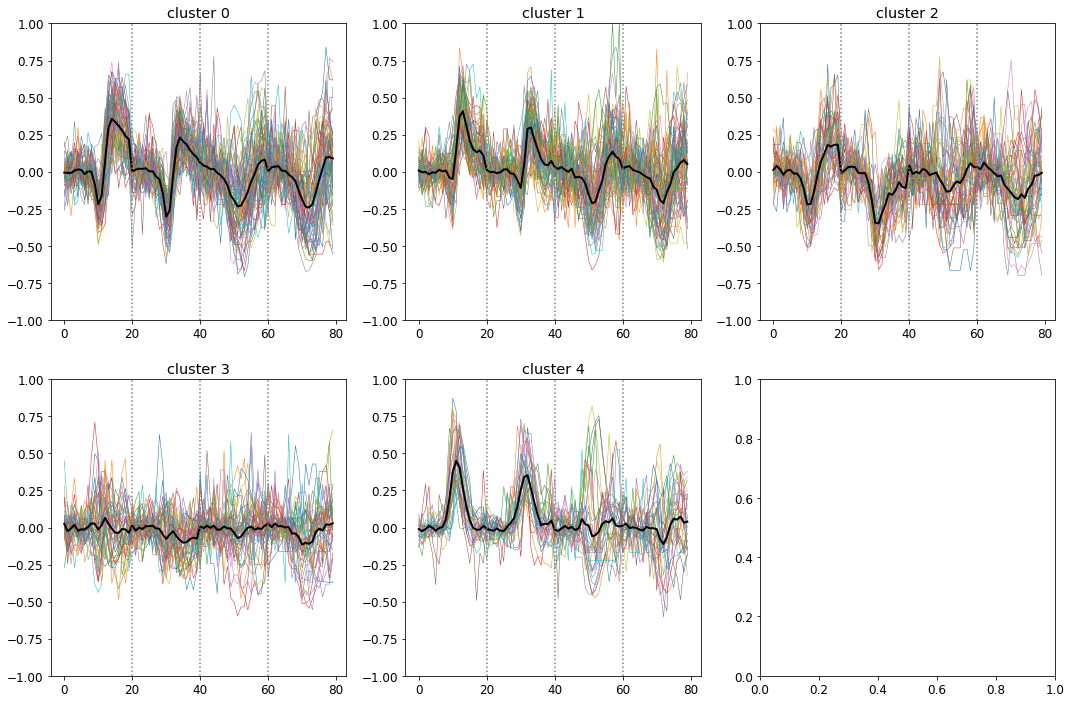

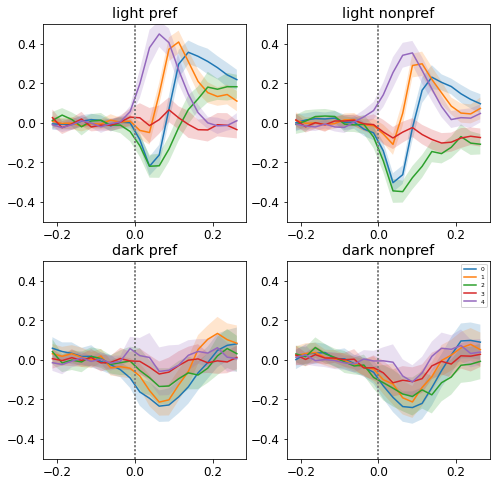

In [973]:
### set baseline/evoked periods for analysis
# baseline = [0,15]
# evoked = [41,51] #49 is about 200ms
print('baseline period:, ',time_pts[baseline[0]:baseline[1]])
print('evoked times: ',time_pts[evoked[0]:evoked[1]])

raw_psth_keys = ['FmLt_rightsacc_avg_gaze_shift_dHead','FmLt_leftsacc_avg_gaze_shift_dHead','FmDk_rightsacc_avg_gaze_shift_dHead','FmDk_leftsacc_avg_gaze_shift_dHead']

df = og_df.copy()

gaze_lt_pref_200ms_win_psth, gaze_lt_nonpref_200ms_win_psth, gaze_lt_pref_200ms_win_peak,\
gaze_lt_nonpref_200ms_win_peak, gaze_lt_pref_200ms_win_peakind, gaze_lt_nonpref_200ms_win_peakind,\
gaze_dk_pref_200ms_win_psth, gaze_dk_nonpref_200ms_win_psth, gaze_dk_pref_200ms_win_peak,\
gaze_dk_nonpref_200ms_win_peak, gaze_dk_pref_200ms_win_peakind, gaze_dk_nonpref_200ms_win_peakind = ([] for i in range(12))

for index,row in df.iterrows():
    Rlttrace = row[raw_psth_keys[0]]
    trace = Rlttrace-np.mean(Rlttrace[baseline[0]:baseline[1]]) #removed np.abs
    ev = trace[evoked[0]:evoked[1]]
    Rltgaze_peak = ev.max()
    Rltgaze_peak_ind = ev.argmax()+evoked[0]

    Llttrace = row[raw_psth_keys[1]]
    trace = Llttrace-np.mean(Llttrace[baseline[0]:baseline[1]]) #removed np.abs
    ev = trace[evoked[0]:evoked[1]]
    Lltgaze_peak = ev.max()
    Lltgaze_peak_ind = ev.argmax()+evoked[0]

    Rdktrace = row[raw_psth_keys[2]]
    trace = Rdktrace-np.mean(Rdktrace[baseline[0]:baseline[1]]) #removed np.abs
    ev = trace[evoked[0]:evoked[1]]
    Rdkgaze_peak = ev.max()
    Rdkgaze_peak_ind = ev.argmax()+evoked[0]

    Ldktrace = row[raw_psth_keys[3]]
    trace = Ldktrace-np.mean(Ldktrace[baseline[0]:baseline[1]]) #removed np.abs
    ev = trace[evoked[0]:evoked[1]]
    Ldkgaze_peak = ev.max()
    Ldkgaze_peak_ind = ev.argmax()+evoked[0]

    if Rltgaze_peak>Lltgaze_peak:
        gaze_lt_pref_200ms_win_psth.append(Rlttrace)
        gaze_lt_nonpref_200ms_win_psth.append(Llttrace)
        gaze_lt_pref_200ms_win_peak.append(Rltgaze_peak)
        gaze_lt_nonpref_200ms_win_peak.append(Lltgaze_peak)
        gaze_lt_pref_200ms_win_peakind.append(Rltgaze_peak_ind)
        gaze_lt_nonpref_200ms_win_peakind.append(Lltgaze_peak_ind)
        gaze_dk_pref_200ms_win_psth.append(Rdktrace)
        gaze_dk_nonpref_200ms_win_psth.append(Ldktrace)
        gaze_dk_pref_200ms_win_peak.append(Rdkgaze_peak)
        gaze_dk_nonpref_200ms_win_peak.append(Ldkgaze_peak)
        gaze_dk_pref_200ms_win_peakind.append(Rdkgaze_peak_ind)
        gaze_dk_nonpref_200ms_win_peakind.append(Ldkgaze_peak_ind)
    else:
        gaze_lt_pref_200ms_win_psth.append(Llttrace)
        gaze_lt_nonpref_200ms_win_psth.append(Rlttrace)
        gaze_lt_pref_200ms_win_peak.append(Lltgaze_peak)
        gaze_lt_nonpref_200ms_win_peak.append(Rltgaze_peak)
        gaze_lt_pref_200ms_win_peakind.append(Lltgaze_peak_ind)
        gaze_lt_nonpref_200ms_win_peakind.append(Rltgaze_peak_ind)
        gaze_dk_pref_200ms_win_psth.append(Ldktrace)
        gaze_dk_nonpref_200ms_win_psth.append(Rdktrace)
        gaze_dk_pref_200ms_win_peak.append(Ldkgaze_peak)
        gaze_dk_nonpref_200ms_win_peak.append(Rdkgaze_peak)
        gaze_dk_pref_200ms_win_peakind.append(Ldkgaze_peak_ind)
        gaze_dk_nonpref_200ms_win_peakind.append(Rdkgaze_peak_ind)

df['gaze_lt_pref_200ms_win_psth'] = gaze_lt_pref_200ms_win_psth
df['gaze_lt_nonpref_200ms_win_psth'] = gaze_lt_nonpref_200ms_win_psth
df['gaze_lt_pref_200ms_win_peak'] = gaze_lt_pref_200ms_win_peak
df['gaze_lt_nonpref_200ms_win_peak'] = gaze_lt_nonpref_200ms_win_peak
df['gaze_lt_pref_200ms_win_peakind'] = gaze_lt_pref_200ms_win_peakind
df['gaze_lt_nonpref_200ms_win_peakind'] = gaze_lt_nonpref_200ms_win_peakind
df['gaze_dk_pref_200ms_win_psth'] = gaze_dk_pref_200ms_win_psth
df['gaze_dk_nonpref_200ms_win_psth'] = gaze_dk_nonpref_200ms_win_psth
df['gaze_dk_pref_200ms_win_peak'] = gaze_dk_pref_200ms_win_peak
df['gaze_dk_nonpref_200ms_win_peak'] = gaze_dk_nonpref_200ms_win_peak
df['gaze_dk_pref_200ms_win_peakind'] = gaze_dk_pref_200ms_win_peakind
df['gaze_dk_nonpref_200ms_win_peakind'] = gaze_dk_nonpref_200ms_win_peakind

### sort the df by something
# df = df.sort_values('gaze_label') #sort by cluster
# df = df.sort_values('tf_pref') #sort by tf preference
df = df.sort_values('gaze_lt_pref_200ms_win_peakind')

df.reset_index(inplace=True,drop=True)

# psth_keys = ['FmLt_rightsacc_avg_gaze_shift_dHead','FmLt_leftsacc_avg_gaze_shift_dHead']
psth_keys = ['gaze_lt_pref_200ms_win_psth','gaze_lt_nonpref_200ms_win_psth','gaze_dk_pref_200ms_win_psth','gaze_dk_nonpref_200ms_win_psth']
gaze_psth = np.zeros((len(psth_keys),len(df),len(df[psth_keys[0]].iloc[0])))
raw_gaze_psth = gaze_psth.copy()
for pnp,psth_key in enumerate(psth_keys):
    for i,(item,peak) in enumerate(zip(df[psth_key],df['gaze_lt_pref_200ms_win_peak'])):
        gaze_psth[pnp,i,:] = (item-np.mean(item[baseline[0]:baseline[1]]))/np.max(item)#peak (not using peak of light pref currently) #subtract off min here instead of baseline, sort
        raw_gaze_psth[pnp,i,:] = item
        #mds or 1D UMAP or TCA, sort based on that value; sort on entire dataset and label group for each unit
        #sort on pref tf or sf

#redo pca and kmeans
pref = gaze_psth[0,:,baseline[0]:evoked[1]]
npref = gaze_psth[1,:,baseline[0]:evoked[1]]
dk_pref = gaze_psth[2,:,baseline[0]:evoked[1]]
dk_npref = gaze_psth[3,:,baseline[0]:evoked[1]]
pca_input = np.hstack((pref,npref))
all_data = np.hstack((pref,npref,dk_pref,dk_npref))
tp = time_pts[baseline[0]:evoked[1]]

n_k = 5
pca = PCA(n_components=n_k)
reduced_data = pca.fit_transform(pca_input)
kmeans = KMeans(init='k-means++', n_clusters=n_k, n_init=1000) #maybe
cluster_data = kmeans.fit_transform(reduced_data)

fig,axs = plt.subplots(2,3,figsize=(3*6,2*6))
axs = axs.ravel()
for k in range(n_k):
    ax = axs[k]
    grp_psth = all_data[np.where(kmeans.labels_==k)[0],:]
    for p in grp_psth:
        ax.plot(p,linewidth=0.5)
    grp_trace = np.mean(grp_psth,axis=0)
    ax.plot(grp_trace,'k',linewidth=2,label=str(k))
    for g in range(1,4):
        ax.plot([len(tp)*g,len(tp)*g],[-1,1],':',color=[0.5,0.5,0.5])
    ax.set_title('cluster %d' % k)
    ax.set_ylim(-1,1)

fig,axs = plt.subplots(2,2,figsize=(8,8))
axs = axs.ravel()
ylim=0.5

ax = axs[0]
for k in range(n_k):
    grp_psth = pref[np.where(kmeans.labels_==k)[0],:]
    y=np.mean(grp_psth,axis=0)
    err = np.std(grp_psth,axis=0)/np.sqrt(numAni)
    ax.plot(tp,y)
    ax.fill_between(tp,y-err,y+err,alpha=0.2)
    ax.plot([0,0],[-ylim,ylim],':',color=[0.5,0.5,0.5])
ax.set_title('light pref')

ax = axs[1]
for k in range(n_k):
    grp_psth = npref[np.where(kmeans.labels_==k)[0],:]
    y=np.mean(grp_psth,axis=0)
    err = np.std(grp_psth,axis=0)/np.sqrt(numAni)
    ax.plot(tp,y)
    ax.fill_between(tp,y-err,y+err,alpha=0.2)
    ax.plot([0,0],[-ylim,ylim],':',color=[0.5,0.5,0.5])
ax.set_title('light nonpref')

ax = axs[2]
for k in range(n_k):
    grp_psth = dk_pref[np.where(kmeans.labels_==k)[0],:]
    y=np.mean(grp_psth,axis=0)
    err = np.std(grp_psth,axis=0)/np.sqrt(numAni)
    ax.plot(tp,y)
    ax.fill_between(tp,y-err,y+err,alpha=0.2)
    ax.plot([0,0],[-ylim,ylim],':',color=[0.5,0.5,0.5])
ax.set_title('dark pref')

ax = axs[3]
for k in range(n_k):
    grp_psth = dk_npref[np.where(kmeans.labels_==k)[0],:]
    y=np.mean(grp_psth,axis=0)
    err = np.std(grp_psth,axis=0)/np.sqrt(numAni)
    ax.plot(tp,y,label=k)
    ax.fill_between(tp,y-err,y+err,alpha=0.2)
    ax.plot([0,0],[-ylim,ylim],':',color=[0.5,0.5,0.5])
ax.set_title('dark nonpref')
ax.legend(fontsize=6)
for i in range(4):
    axs[i].set_ylim(-0.5,0.5)

In [1043]:
time_pts[41]

0.037500000000000866

In [974]:
df['gaze_label'] = kmeans.labels_
df['gaze_label'] = df['gaze_label'].replace(0,'2_biphasic')
df['gaze_label'] = df['gaze_label'].replace(1,'1_late')
df['gaze_label'] = df['gaze_label'].replace(2,'3_negative')
df['gaze_label'] = df['gaze_label'].replace(3,'4_unrespGaze')
df['gaze_label'] = df['gaze_label'].replace(4,'0_early')
gaze_keys = np.unique(df['gaze_label'])

### sort the df by something
# df = df.sort_values('gaze_label') #sort by cluster
# df = df.sort_values('tf_pref') #sort by tf preference
unresp = df[df['gaze_label']=='4_unrespGaze'] #find unrespGaze units
unresp.reset_index(inplace=True,drop=True)
df = df[df['gaze_label']!='4_unrespGaze'] #remove unrespGaze units
df.reset_index(inplace=True,drop=True)
df = df.sort_values('gaze_lt_pref_200ms_win_peakind')
df = pd.concat([df,unresp],ignore_index=True)
df.reset_index(inplace=True,drop=True)

In [1039]:
early_motor_idxs = [41, 41, 41, 41, 41, 42, 42, 42, 43]
early_general_idxs = [41, 41, 41, 41, 41, 42, 42, 42, 42, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 44, 44, 44]
print('motor peak = %0.3fs, early peak = %0.3fs' % (np.mean([time_pts[i] for i in early_motor_idxs]),np.mean([time_pts[i] for i in early_general_idxs])))

motor peak = 0.051s, early peak = 0.075s


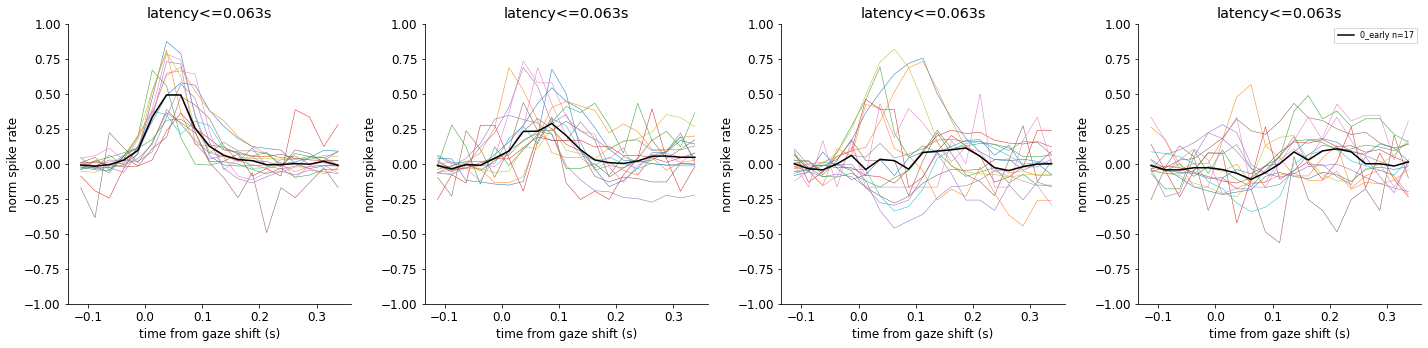

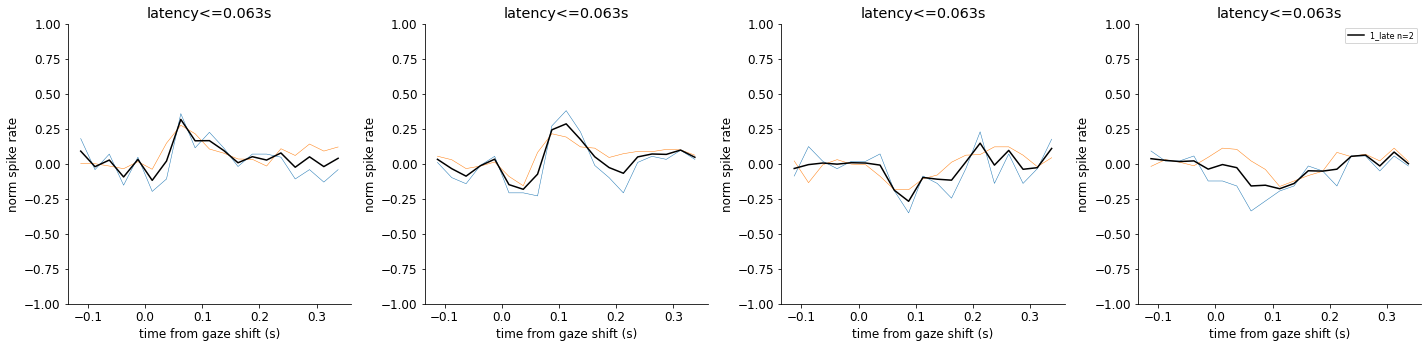

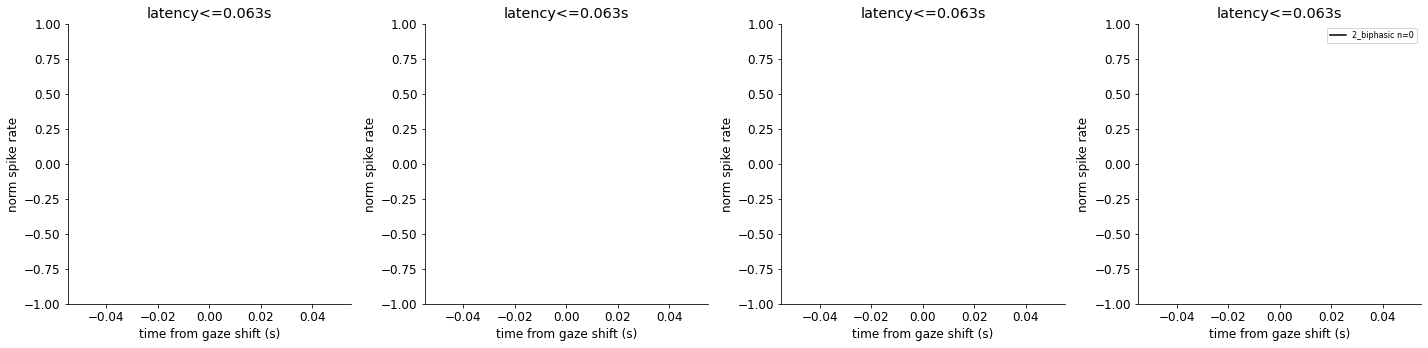

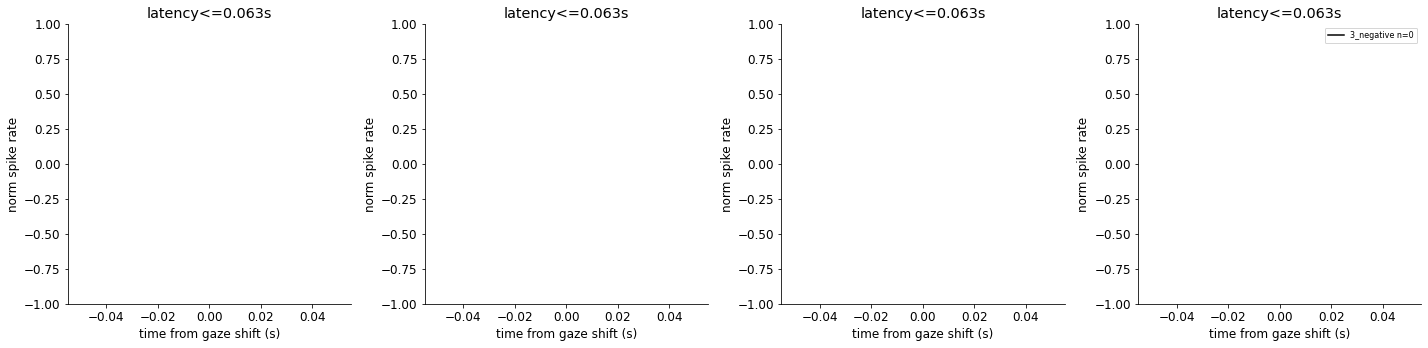

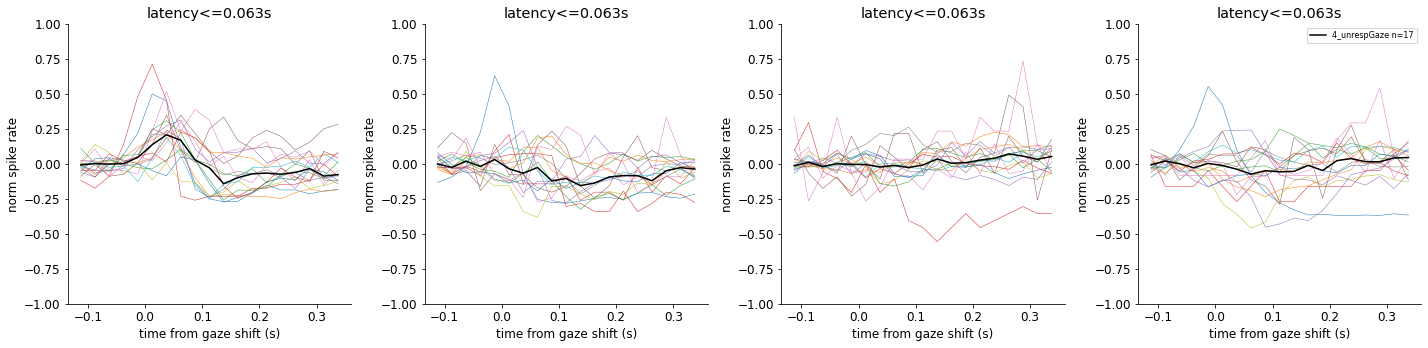

In [1084]:
save_pdf = True
pdf_file = r'T:/freely_moving_ephys/gaze_shift_analysis_ltdk_cluster_traces.pdf'
pp = PdfPages(pdf_file)

ev_resp_idx = (np.abs(np.mean(raw_gaze_psth[0,:,evoked[0]:evoked[1]],axis=1)-np.mean(raw_gaze_psth[0,:,baseline[0]:baseline[1]],axis=1))>1)
# peak_idx = df['gaze_lt_pref_200ms_win_peakind']<=43
dirsel_idxs = (df['gaze_lt_pref_200ms_win_peak']/df['gaze_lt_nonpref_200ms_win_peak']>2)
# fig, axs = plt.subplots(1, len(psth_keys),figsize=(5*len(psth_keys),5))
# axs = axs.ravel()
peak_ts =[41,42,43,44,45]
peak_t = 42
# for p,peak_t in enumerate(peak_ts):
for g,label in enumerate(gaze_keys):
    peak_idx = df['gaze_lt_pref_200ms_win_peakind']<=peak_t
    filt_idxs = np.where((df['gaze_label']==label)&peak_idx)[0]
    gaze_psth_plt = gaze_psth[:,filt_idxs,:]
    # print([item for item in df['gaze_lt_pref_200ms_win_peakind'].iloc[filt_idxs]])

    fig, axs = plt.subplots(1, len(psth_keys),figsize=(5*len(psth_keys),5))

    for i in range(len(psth_keys)):
        ax = axs[i]
        ax.set_title('latency<=%0.3fs' % time_pts[peak_t])
        for item in gaze_psth_plt[i,:,trange[0]:trange[1]]:
            ax.plot(tp,item,linewidth=0.5)
        y=np.median(gaze_psth_plt[i,:,trange[0]:trange[1]],axis=0)
        err = np.std(gaze_psth_plt[i,:,trange[0]:trange[1]],axis=0)/np.sqrt(numAni)
        ax.plot(tp,y,'k-',label=label + ' n=%d' % len(filt_idxs))
        # ax.fill_between(tp,y-err,y+err,alpha=0.2)
        ax.set_ylabel('norm spike rate')
        ax.set_xlabel('time from gaze shift (s)')
        ax.set_ylim(-1,1)
        ax = xy_axis(ax)
    ax.legend(fontsize=8)

    fig.tight_layout()
    if save_pdf:
        pp.savefig(fig)
        # plt.close(fig)

pp.close()

In [975]:
save_pdf = True
pdf_file = r'T:/freely_moving_ephys/gaze_shift_analysis_ltdk_all_data.pdf'
pp = PdfPages(pdf_file)

# ### if filtering on something, do this part first
# psth_keys = ['gaze_lt_pref_200ms_win_psth','gaze_lt_nonpref_200ms_win_psth','gaze_dk_pref_200ms_win_psth','gaze_dk_nonpref_200ms_win_psth']
# gaze_psth = np.zeros((len(psth_keys),len(df),len(df[psth_keys[0]].iloc[0])))
# raw_gaze_psth = gaze_psth.copy()
# for pnp,psth_key in enumerate(psth_keys):
#     for i,item in enumerate(df[psth_key]):
#         gaze_psth[pnp,i,:] = (item-np.mean(item[baseline[0]:baseline[1]]))/np.max(item) #subtract off min here instead of baseline, sort
#         raw_gaze_psth[pnp,i,:] = item

#filter for units that respond both revcheck or gratings
# rc_resp = np.where(np.abs(np.mean(raw_gaze_psth[-1,:,evoked[0]:evoked[1]],axis=1)-np.mean(raw_gaze_psth[-1,:,baseline[0]:baseline[1]],axis=1))>1)[0]#np.where(np.nanmean(raw_gaze_psth[-1,:,:],axis=1)>1)[0]
# # gt_resp = np.where(np.abs(np.mean(raw_grat_psth[:,5:14],axis=1)-np.mean(raw_grat_psth[:,:5],axis=1))>1)[0]#np.where(df['responsive_to_gratings'])[0]
# gt_resp = np.where(np.mean(raw_grat_psth[:,5:14],axis=1)-np.mean(raw_grat_psth[:,:5],axis=1)>2)[0]#np.where(df['responsive_to_gratings'])[0]
df_plot = df.copy()#.iloc[gt_resp]


# psth_keys = ['FmLt_rightsacc_avg_gaze_shift_dHead','FmLt_leftsacc_avg_gaze_shift_dHead']
psth_keys = ['gaze_lt_pref_200ms_win_psth','gaze_lt_nonpref_200ms_win_psth','gaze_dk_pref_200ms_win_psth','gaze_dk_nonpref_200ms_win_psth']
gaze_psth = np.zeros((len(psth_keys),len(df_plot),len(df_plot[psth_keys[0]].iloc[0])))
raw_gaze_psth = gaze_psth.copy()
for pnp,psth_key in enumerate(psth_keys):
    for i,item in enumerate(df_plot[psth_key]):
        gaze_psth[pnp,i,:] = (item-np.mean(item[baseline[0]:baseline[1]]))/np.max(item) #subtract off min here instead of baseline, sort
        raw_gaze_psth[pnp,i,:] = item

mn_gaze_psth = np.zeros((gaze_psth.shape[0],len(gaze_keys),gaze_psth.shape[2]))
sem_gaze_psth = mn_gaze_psth.copy()
for gt,gaze_type in enumerate(gaze_keys):
    for pnp in range(gaze_psth.shape[0]):
        mn = np.nanmedian(gaze_psth[pnp,np.where(df_plot['gaze_label']==gaze_type)[0],:],axis=0)
        sem = np.nanstd(gaze_psth[pnp,np.where(df_plot['gaze_label']==gaze_type)[0],:],axis=0)/np.sqrt(numAni)
        mn_gaze_psth[pnp,gt,:] = mn
        sem_gaze_psth[pnp,gt,:] = sem

print('there are %d gaze shift clusters' % len(gaze_keys))
print('gaze responses psth are shape %s, time points are shape %s' % (str(gaze_psth.shape),str(time_pts.shape)))
print('mean gaze psth shape is %s' % str(mn_gaze_psth.shape))

titles = ['light pref','light nonpref','dark pref','dark nonpref']
# titles = ['right','left']
trange = [35,54]
col_lim = [-0.5,0.5]

# ### find indices for boundaries between clusters for plotting
# boundaries = []
# for key in gaze_keys[:-1]:
#     boundaries.append(np.where(df_plot['gaze_label']==key)[0][0])

tp = time_pts[trange[0]:trange[1]]
zc = zero_crossing(tp)
plt_ticks = np.arange(len(tp))+0.5
real_ticks = tp+np.min(np.abs(tp))
zero_ind = np.where(real_ticks==0)[0][0]



### plot average PSTH by group
fig, axs = plt.subplots(1, len(psth_keys),figsize=(5*len(psth_keys),5))
axs = axs.ravel()
for i in range(len(psth_keys)):
    ax = axs[i]
    ax.set_title(titles[i])
    for g,gk in enumerate(gaze_keys):
        y=mn_gaze_psth[i,g,trange[0]:trange[1]]
        err = sem_gaze_psth[i,g,trange[0]:trange[1]]
        ax.plot(tp,y,label=gk)
        ax.fill_between(tp,y-err,y+err,alpha=0.2)
    ax.set_ylabel('norm spike rate')
    ax.set_xlabel('time from gaze shift (s)')
    ax.set_ylim(-0.75,0.75)
    ax = xy_axis(ax)

fig.suptitle('mean gaze shift responses')
fig.tight_layout()
if save_pdf:
    pp.savefig(fig)
    plt.close(fig)



### plot heatmap of group PSTHs
fig, axs = plt.subplots(1,len(psth_keys),figsize=(5*len(psth_keys),2),facecolor='white')
axs = axs.ravel()
for i in range(len(psth_keys)):
    ax = axs[i]
    im = mn_gaze_psth[i,:,trange[0]:trange[1]]
    ax.imshow(im,cmap='rainbow',vmin=col_lim[0],vmax=col_lim[1])
    ax.plot([zc, zc] , [0,im.shape[0]-1], ':', color=[0.5,0.5,0.5])
    ax.set_title(titles[i])
    ax.set_ylabel('cluster')
    ax.set_xlabel('time from gaze shift (s)')
    ax.set_xticks([0,plt_ticks[zero_ind],len(real_ticks)])
    ax.set_xticklabels(np.round([real_ticks[0],real_ticks[zero_ind],real_ticks[-1]],1))
    ax = xy_axis(ax)

fig.suptitle('mean gaze shift responses')
# fig.tight_layout()
if save_pdf:
    pp.savefig(fig)
    plt.close(fig)



### plot individual unit responses
fig, axs = plt.subplots(1,len(psth_keys),figsize=(5*len(psth_keys),10),facecolor='white')
axs = axs.ravel()
for i in range(len(psth_keys)):
    ax = axs[i]
    # im = gaze_psth[i,:,trange[0]:trange[1]]
    im = gaze_psth[i,:,trange[0]:trange[1]]
    ax.imshow(im,cmap='rainbow',vmin=col_lim[0],vmax=col_lim[1])
    # for b in boundaries:
    #     ax.plot(np.arange(im.shape[1]), [b] * im.shape[1], 'k-', linewidth=1)
    ax.plot([zc, zc] , [0,im.shape[0]-1], ':', color=[0.5,0.5,0.5])
    ax.set_title(titles[i])
    ax.set_ylabel('unit #')
    ax.set_xlabel('time from gaze shift (s)')
    
    ax.set_xticks([0,plt_ticks[zero_ind],len(real_ticks)])
    ax.set_xticklabels(np.round([real_ticks[0],real_ticks[zero_ind],real_ticks[-1]],1))
    ax.set_aspect('auto')
    ax = xy_axis(ax)

fig.suptitle('individual gaze shift responses by cluster')
# fig.tight_layout()
if save_pdf:
    pp.savefig(fig)
    plt.close(fig)

pp.close()

there are 5 gaze shift clusters
gaze responses psth are shape (4, 269, 83), time points are shape (83,)
mean gaze psth shape is (4, 5, 83)


In [976]:
[key for key in df.keys()]

['Amplitude',
 'ContamPct',
 'KSLabel',
 'amp',
 'ch',
 'depth',
 'fr',
 'group',
 'FmLt_n_spikes',
 'sh',
 'waveform',
 'FmLt_spikeT',
 't0',
 'FmLt_spikeTraw',
 'FmLt_rate',
 'FmLt_contrast_tuning_bins',
 'FmLt_contrast_tuning',
 'FmLt_contrast_tuning_err',
 'FmLt_spike_triggered_average',
 'FmLt_spike_triggered_variance',
 'FmLt_rightsacc_avg',
 'FmLt_leftsacc_avg',
 'FmLt_rightsacc_avg_gaze_shift_dEye',
 'FmLt_leftsacc_avg_gaze_shift_dEye',
 'FmLt_rightsacc_avg_comp_dEye',
 'FmLt_leftsacc_avg_comp_dEye',
 'FmLt_rightsacc_avg_gaze_shift_dHead',
 'FmLt_leftsacc_avg_gaze_shift_dHead',
 'FmLt_rightsacc_avg_comp_dHead',
 'FmLt_leftsacc_avg_comp_dHead',
 'FmLt_pupilradius_tuning_bins',
 'FmLt_pupilradius_tuning',
 'FmLt_pupilradius_tuning_err',
 'FmLt_theta_tuning_bins',
 'FmLt_theta_tuning',
 'FmLt_theta_tuning_err',
 'FmLt_phi_tuning_bins',
 'FmLt_phi_tuning',
 'FmLt_phi_tuning_err',
 'FmLt_gyroz_tuning_bins',
 'FmLt_gyroz_tuning',
 'FmLt_gyroz_tuning_err',
 'FmLt_gyrox_tuning_bins',
 

In [ ]:


# mn_gaze_psth = np.zeros((gaze_psth.shape[0],len(gaze_keys),gaze_psth.shape[2]))
# sem_gaze_psth = mn_gaze_psth.copy()
# for gt,gaze_type in enumerate(gaze_keys):
#     for pnp in range(gaze_psth.shape[0]):
#         mn = np.nanmedian(gaze_psth[pnp,np.where(df['gaze_label']==gaze_type)[0],:],axis=0)
#         sem = np.nanstd(gaze_psth[pnp,np.where(df['gaze_label']==gaze_type)[0],:],axis=0)/np.sqrt(numAni)
#         mn_gaze_psth[pnp,gt,:] = mn
#         sem_gaze_psth[pnp,gt,:] = sem
        
# # rc_responsive_gaze_psth = gaze_psth[:,np.where(np.nanmean(raw_gaze_psth[1,:,:],axis=1)>1)[0],:]

# print('there are %d gaze shift clusters' % len(gaze_keys))
# print('gaze responses psth are shape %s, time points are shape %s' % (str(gaze_psth.shape),str(time_pts.shape)))
# print('mean gaze psth shape is %s' % str(mn_gaze_psth.shape))


# save_pdf = True
# pdf_file = r'T:/freely_moving_ephys/gaze_shift_analysis_lightdark.pdf'
# pp = PdfPages(pdf_file)

# titles = ['light pref','light non-pref','dark pref','dark non-pref']
# # titles = ['right','left']
# trange = [35,54]
# col_lim = [-0.5,0.5]

# ### find indices for boundaries between clusters for plotting
# boundaries = []
# for key in gaze_keys[:-1]:
#     boundaries.append(np.where(df['gaze_label']==key)[0][0])

# tp = time_pts[trange[0]:trange[1]]
# zc = zero_crossing(tp)
# plt_ticks = np.arange(len(tp))+0.5
# real_ticks = tp+np.min(np.abs(tp))
# zero_ind = np.where(real_ticks==0)[0][0]

# fig, axs = plt.subplots(1, len(psth_keys), figsize=(5*len(psth_keys),5))
# axs = axs.ravel()
# for i in range(len(psth_keys)):
#     ax = axs[i]
#     ax.set_title(titles[i])
#     for g,gk in enumerate(gaze_keys):
#         y=mn_gaze_psth[i,g,trange[0]:trange[1]]
#         err = sem_gaze_psth[i,g,trange[0]:trange[1]]
#         ax.plot(tp,y)
#         ax.fill_between(tp,y-err,y+err,alpha=0.2)
#     ax.set_ylabel('norm spike rate')
#     ax.set_xlabel('time from gaze shift (s)')
#     ax.set_ylim(-0.6,0.6)
#     ax = xy_axis(ax)
# # ax.get_yaxis().set_visible(False)
# fig.suptitle('mean gaze shift responses')
# fig.tight_layout()
# if save_pdf:
#     pp.savefig(fig)
#     plt.close(fig)


# fig, axs = plt.subplots(1,len(psth_keys),figsize=(5*len(psth_keys),2),facecolor='white')
# axs = axs.ravel()
# for i in range(len(psth_keys)):
#     ax = axs[i]
#     im = mn_gaze_psth[i,:,trange[0]:trange[1]]
#     ax.imshow(im,cmap='rainbow',vmin=col_lim[0],vmax=col_lim[1])
#     ax.plot([zc, zc] , [0,im.shape[0]-1], ':', color=[0.5,0.5,0.5])
#     ax.set_title(titles[i])
#     ax.set_ylabel('cluster')
#     ax.set_xlabel('time from gaze shift (s)')
#     ax.set_xticks([0,plt_ticks[zero_ind],len(real_ticks)])
#     ax.set_xticklabels(np.round([real_ticks[0],real_ticks[zero_ind],real_ticks[-1]],1))
#     ax = xy_axis(ax)
# # ax.get_yaxis().set_visible(False)
# fig.suptitle('mean gaze shift responses')
# fig.tight_layout()
# if save_pdf:
#     pp.savefig(fig)
#     plt.close(fig)

# fig, axs = plt.subplots(1,len(psth_keys),figsize=(5*len(psth_keys),10),facecolor='white')
# axs = axs.ravel()
# for i in range(len(psth_keys)):
#     ax = axs[i]
#     # im = gaze_psth[i,:,trange[0]:trange[1]]
#     im = gaze_psth[i,:,trange[0]:trange[1]]
#     ax.imshow(im,cmap='rainbow',vmin=col_lim[0],vmax=col_lim[1])
#     # for b in boundaries:
#     #     ax.plot(np.arange(im.shape[1]), [b] * im.shape[1], 'k-', linewidth=1)
#     ax.plot([zc, zc] , [0,im.shape[0]-1], ':', color=[0.5,0.5,0.5])
#     ax.set_title(titles[i])
#     ax.set_ylabel('unit #')
#     ax.set_xlabel('time from gaze shift (s)')
    
#     ax.set_xticks([0,plt_ticks[zero_ind],len(real_ticks)])
#     ax.set_xticklabels(np.round([real_ticks[0],real_ticks[zero_ind],real_ticks[-1]],1))
#     ax.set_aspect('auto')
#     ax = xy_axis(ax)
# # ax.get_yaxis().set_visible(False)
# fig.suptitle('individual gaze shift responses by cluster')
# # fig.tight_layout()
# if save_pdf:
#     pp.savefig(fig)
#     plt.close(fig)

# # fig, axs = plt.subplots(1,2,figsize=(10,5))

# # ax = axs[0]
# # ax.plot(df['gaze_pref_200ms_win_peakind'],df['tf_pref'],'ko')
# # ax.set_xlabel('positive peak time (s)')
# # ax.set_ylabel('pref TF')
# # ax.set_xticks(np.arange(42,52,2))
# # ax.set_xticklabels(np.round(time_pts[42:52:2],2).tolist())
# # ax = xy_axis(ax)

# # ax = axs[1]
# # ax.plot(df['gaze_pref_200ms_win_peakind'],df['sf_pref'],'ko')
# # ax.set_xlabel('positive peak time (s)')
# # ax.set_ylabel('pref SF')
# # ax.set_xticks(np.arange(42,52,2))
# # ax.set_xticklabels(np.round(time_pts[42:52:2],2).tolist())
# # ax = xy_axis(ax)

# # ax = axs[2]
# # ax.plot(df['gaze_pref_200ms_win_peakind'],df['sf_pref']/df['tf_pref'],'ko')
# # ax.set_xlabel('positive peak time (s)')
# # ax.set_ylabel('pref speed')
# # ax.set_xticks(np.arange(42,52,2))
# # ax.set_xticklabels(np.round(time_pts[42:52:2],2).tolist())
# # ax = xy_axis(ax)

# # if save_pdf:
# #     pp.savefig(fig)
# #     plt.close(fig)

# pp.close()

## concatenate pref & non pref and run PCA

In [1091]:
pref = gaze_psth[0,:,:]#baseline[0]:evoked[1]]
npref = gaze_psth[1,:,:]#baseline[0]:evoked[1]]
dk_pref = gaze_psth[2,:,:]#baseline[0]:evoked[1]]
dk_npref = gaze_psth[3,:,:]#baseline[0]:evoked[1]]
pca_input = np.hstack((pref,dk_pref))
pca_input.shape

(269, 166)

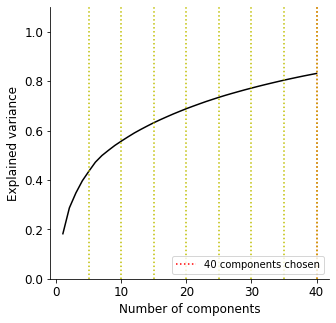

In [1092]:
n_k = 40
pca = PCA(n_components=n_k)
reduced_data = pca.fit_transform(pca_input)

verts = [5,10,15,20,25,30,35,40]
fig, ax = plt.subplots(1,1,figsize=(5,5))
ax.plot(np.arange(1,n_k+1),np.cumsum(pca.explained_variance_ratio_),'k-')
ax.plot([n_k,n_k],[0,2],'r:',label='%s components chosen' % n_k)
for vert in verts:
    ax.plot([vert,vert],[0,2],'y:')
ax.set_ylim(0,1.1)
ax.set_xlabel('Number of components')
ax.set_ylabel('Explained variance')
ax.legend(fontsize=10,loc=4)
ax = xy_axis(ax)

# if save_pdf:
#     pp.savefig(fig)
#     plt.close(fig)


In [1093]:
n_k = 5
pca = PCA(n_components=n_k)
reduced_data = pca.fit_transform(pca_input)

kmeans = KMeans(init='k-means++', n_clusters=n_k, n_init=100) #maybe
cluster_data = kmeans.fit_transform(reduced_data)

5 kmeans clusters


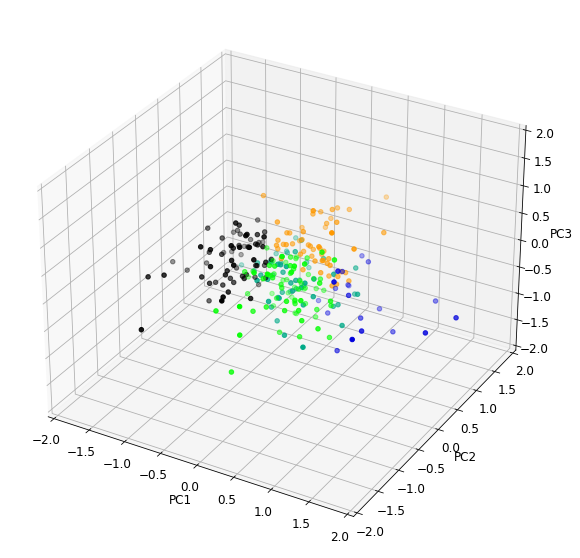

In [1056]:
# plt.rcParams.update({'font.size': 30})
n_k = len(np.unique(kmeans.labels_))
print('%d kmeans clusters' % n_k)
cm = pylab.get_cmap('nipy_spectral')
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

for label in range(n_k):
    col = cm(1.*label/n_k)
    idx = np.where(kmeans.labels_==label)[0]
    pc1 = reduced_data[idx,0]
    pc2 = reduced_data[idx,1]
    pc3 = reduced_data[idx,2]
    ax.scatter(pc1,pc2,pc3,color=col,marker='o')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
lim = 2
ax.set_xlim(-lim,lim)
ax.set_ylim(-lim,lim)
ax.set_zlim(-lim,lim)

plt.show()

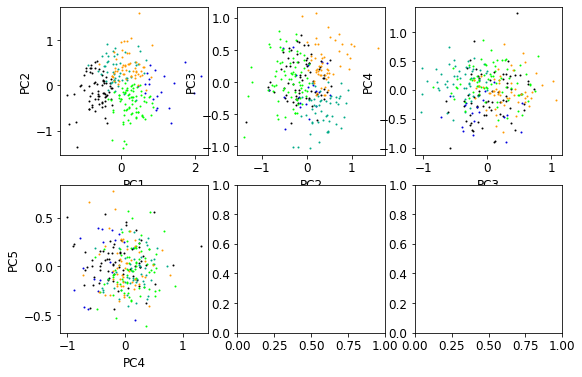

In [1057]:
# plt.rcParams.update({'font.size': 10})
n_k = len(np.unique(kmeans.labels_))
cm = pylab.get_cmap('nipy_spectral')
fig, axs = plt.subplots(2,3,figsize=(3*3,2*3))
axs = axs.ravel()

for pc in range(n_k-1):
    ax = axs[pc]
    for label in range(n_k):
        col = cm(1.*label/n_k)
        idx = np.where(kmeans.labels_==label)[0]
        pc1 = reduced_data[idx,pc]
        pc2 = reduced_data[idx,pc+1]
        ax.plot(pc1,pc2,'o',color=col,markersize=1)
#     ax.axis([-2,2,-2,2])
    ax.set_xlabel('PC%d' % (pc+1))
    ax.set_ylabel('PC%d' % (pc+2))

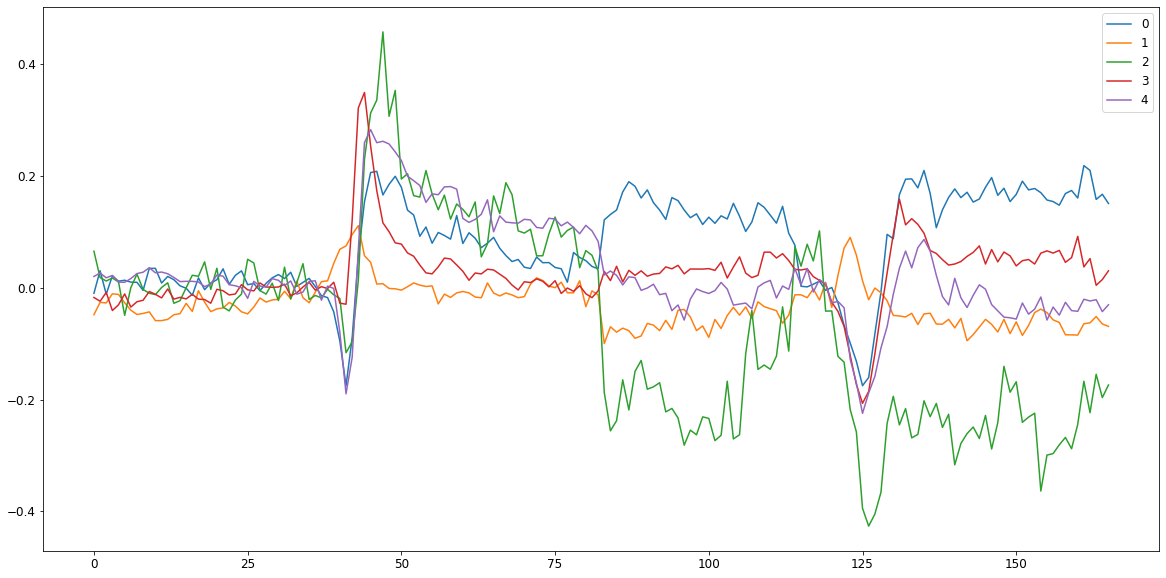

In [1094]:
fig,axs = plt.subplots(1,1,figsize=(20,10))
for k in range(n_k):
    grp_trace = np.mean(pca_input[np.where(kmeans.labels_==k)[0],:],axis=0)
    axs.plot(grp_trace,label=str(k))
axs.legend()

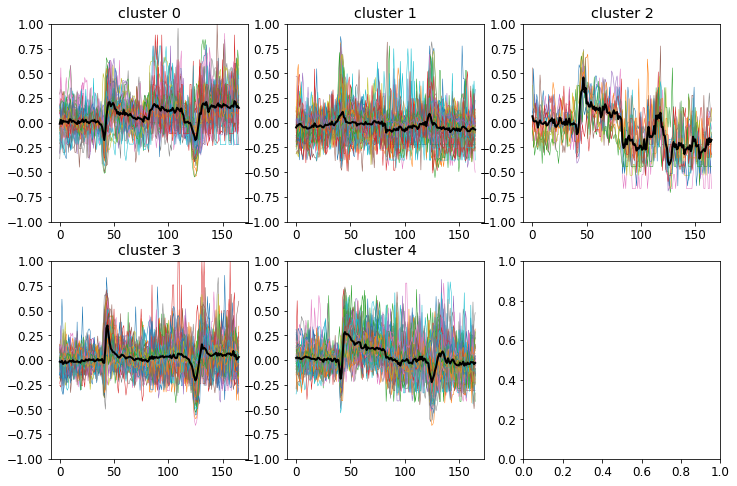

In [1095]:
fig,axs = plt.subplots(2,3,figsize=(12,8))
axs = axs.ravel()
for k in range(n_k):
    ax = axs[k]
    grp_psth = pca_input[np.where(kmeans.labels_==k)[0],:]
    for p in grp_psth:
        ax.plot(p,linewidth=0.5)
    grp_trace = np.mean(grp_psth,axis=0)
    ax.plot(grp_trace,'k',linewidth=2,label=str(k))
    ax.set_title('cluster %d' % k)
    ax.set_ylim(-1,1)

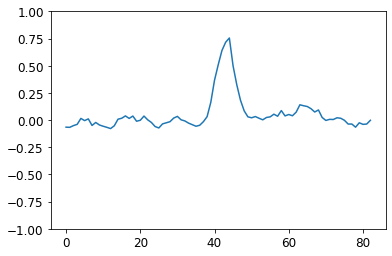

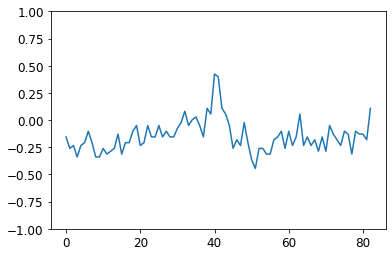

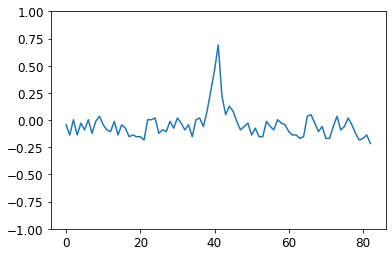

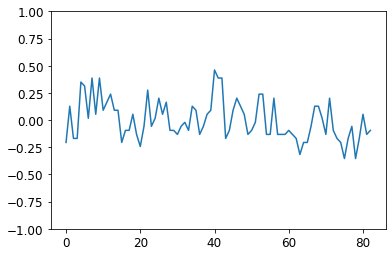

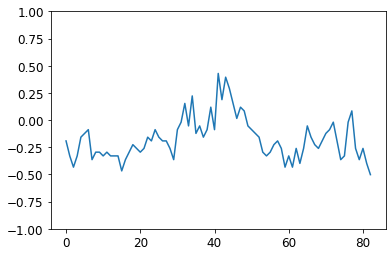

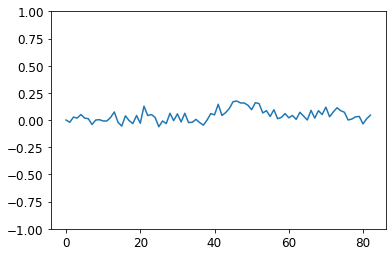

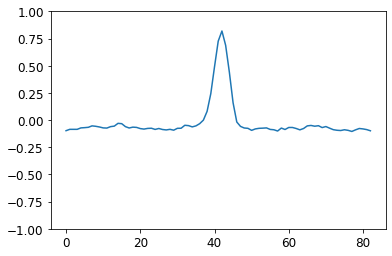

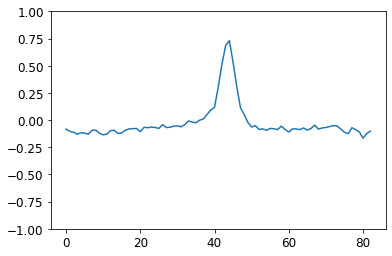

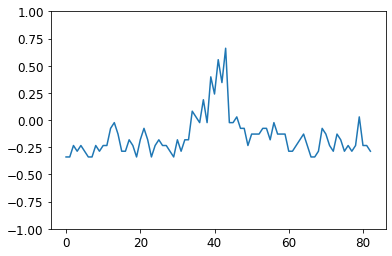

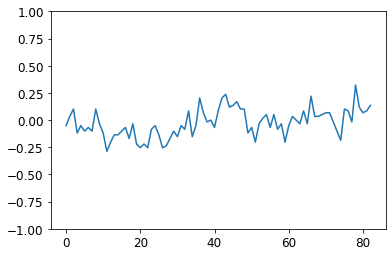

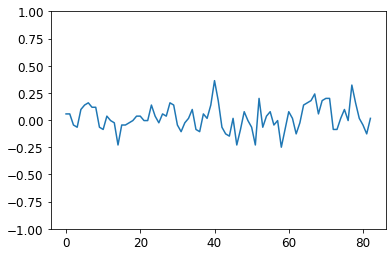

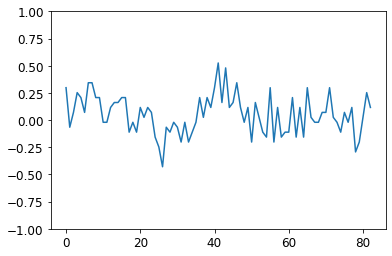

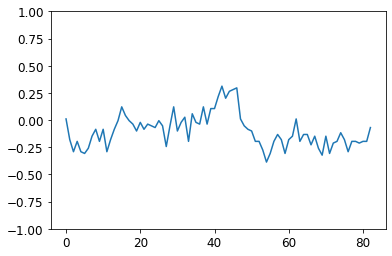

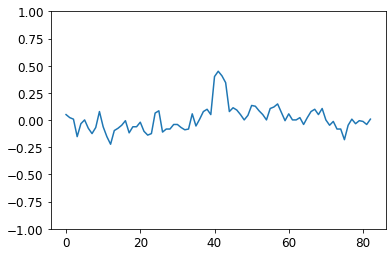

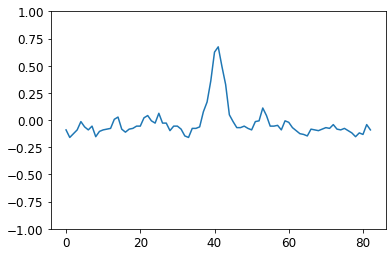

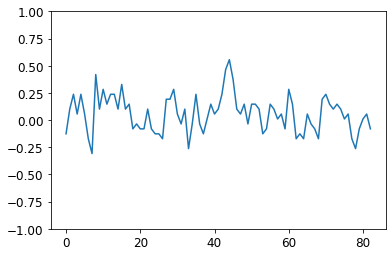

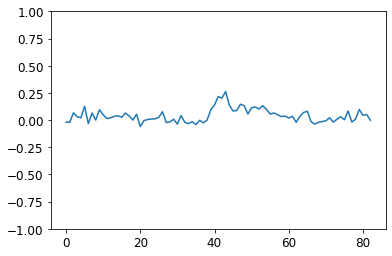

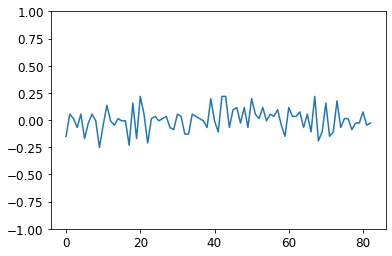

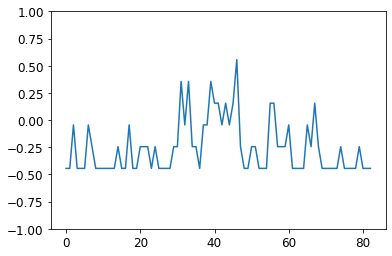

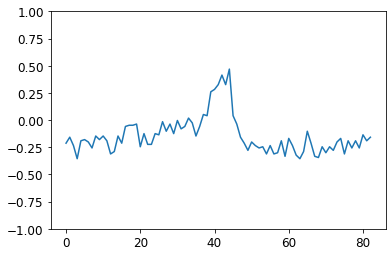

In [1090]:
for j in mvmnt_idx:
    plt.figure()
    plt.plot(gaze_psth[2,j,:])
    plt.ylim(-1,1)

20


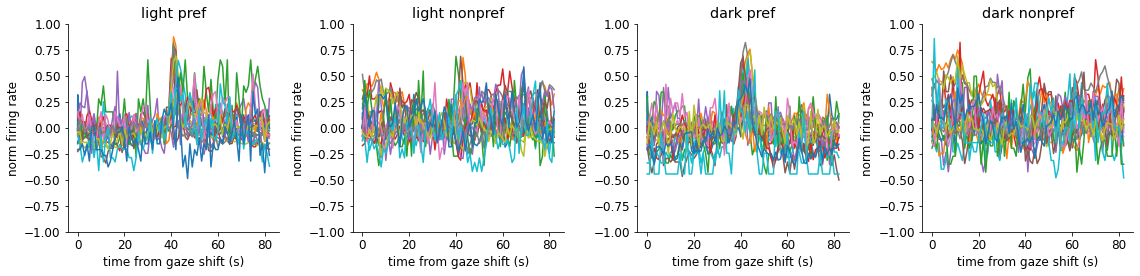

In [1087]:
mvmnt_idx = np.where(kmeans.labels_==1)[0]
print(len(mvmnt_idx))
fig, axs = plt.subplots(1,4,figsize=(16,4))
axs = axs.ravel()
titles = ['light pref','light nonpref','dark pref','dark nonpref']
for i in range(4):
    ax = axs[i]
    y=np.mean(gaze_psth[i,mvmnt_idx,trange[0]:trange[1]],axis=0)
    # err=np.std(gaze_psth[i,mvmnt_idx,trange[0]:trange[1]],axis=0)/np.sqrt(numAni)
    ax.plot(tp,y)
    for j in mvmnt_idx:
        ax.plot(gaze_psth[i,j,:])
    # ax.fill_between(tp,y+err,y-err,alpha=0.2)
    ax.set_ylim(-1,1)
    ax.set_title(titles[i])
    ax.set_ylabel('norm firing rate')
    ax.set_xlabel('time from gaze shift (s)')
    ax = xy_axis(ax)
fig.tight_layout()

In [ ]:
fig,axs = plt.subplots(2,2,figsize=(8,8))
axs = axs.ravel()
ylim=0.5

ax = axs[0]
for k in range(n_k):
    grp_psth = pref[np.where(kmeans.labels_==k)[0],:]
    y=np.mean(grp_psth,axis=0)
    err = np.std(grp_psth,axis=0)/np.sqrt(numAni)
    ax.plot(tp,y)
    ax.fill_between(tp,y-err,y+err,alpha=0.2)
    ax.plot([0,0],[-ylim,ylim],':',color=[0.5,0.5,0.5])
ax.set_title('light pref')

ax = axs[1]
for k in range(n_k):
    grp_psth = npref[np.where(kmeans.labels_==k)[0],:]
    y=np.mean(grp_psth,axis=0)
    err = np.std(grp_psth,axis=0)/np.sqrt(numAni)
    ax.plot(tp,y)
    ax.fill_between(tp,y-err,y+err,alpha=0.2)
    ax.plot([0,0],[-ylim,ylim],':',color=[0.5,0.5,0.5])
ax.set_title('light nonpref')

ax = axs[2]
for k in range(n_k):
    grp_psth = dk_pref[np.where(kmeans.labels_==k)[0],:]
    y=np.mean(grp_psth,axis=0)
    err = np.std(grp_psth,axis=0)/np.sqrt(numAni)
    ax.plot(tp,y)
    ax.fill_between(tp,y-err,y+err,alpha=0.2)
    ax.plot([0,0],[-ylim,ylim],':',color=[0.5,0.5,0.5])
ax.set_title('dark pref')

ax = axs[3]
for k in range(n_k):
    grp_psth = dk_npref[np.where(kmeans.labels_==k)[0],:]
    y=np.mean(grp_psth,axis=0)
    err = np.std(grp_psth,axis=0)/np.sqrt(numAni)
    ax.plot(tp,y,label=k)
    ax.fill_between(tp,y-err,y+err,alpha=0.2)
    ax.plot([0,0],[-ylim,ylim],':',color=[0.5,0.5,0.5])
ax.set_title('dark nonpref')
ax.legend(fontsize=6)
for i in range(4):
    axs[i].set_ylim(-0.5,0.5)

In [1065]:
trange[0]

35

In [776]:
kmeans.labels_.shape

(269,)

# depricated code below

## set up PDF

In [110]:
pdf_file = r'T:/freely_moving_ephys/group_analysis_cluster.pdf'
pp = PdfPages(pdf_file)


def plot_group_eye_head_traces(df,sacs,mov_type,eye_head,baselines,baseline_pts,trace_range,trange,save_pdf,pp,sup):
    
    ### plots clustered traces of spiking vs. eye/head movements and saves a pdf (optional)
    
    ### INPUTS
    ### recs: list of recordings names, e.g. ['fm1']
    ### sacs: list of saccade labels, e.g. ['upsacc','downsacc']
    ### mov_type: list of movement types, e.g. ['gaze_shift','comp']
    ### eye_head: list of eye/head movement labels, e.g. ['dEye','dHead']
    ### trace_range: time range you want to plot over, e.g. [-0.25,0.5]
    ### trange: time points for traces, current is np.arange(-1,1.1-0.025,0.025)
    ### baselines: list of booleans if you want to baseline traces or not, e.g. [True,False]
    ### baseline_pts: indices to use for baseline subtraction, e.g. np.arange(20,36)
    ### save_pdf: boolean value for if you want to save a pdf, e.g. True
    
    ### OUTPUTS
    ### currently none
    
    for rec in recs:
        for eh in eye_head:
            for baseline in baselines:
                fig, axs = plt.subplots(len(mov_type),len(sacs),figsize=(5*len(sacs),5*len(mov_type)))
                for m,m_t in enumerate(mov_type):
                    for s,sac in enumerate(sacs):
                        trace_label = '%s_%s_avg_%s_%s' % (rec,sac,m_t,eh)
                        cluster = trace_label + '_cluster'
#                         cluster = 'fm1_upsacc_avg_gaze_shift_dEye_cluster' #% (eh)
                        clusts = np.unique(df[cluster])
                        len_trace = len(df[trace_label].iloc[-1])

                        for clust in clusts:
                            clust_df = df[df[cluster]==clust]
                            clust_df.reset_index(inplace=True,drop=True)
#                             cluster_label = clust_df[cluster + '_type'].iloc[0]
                            sessions = np.unique(clust_df['session'])
                            num_sess = len(np.unique(clust_df['session']))
                            all_sess = np.zeros((num_sess,len_trace))
                            for se,sess in enumerate(sessions):
                                sess_df = clust_df[clust_df['session']==sess]
                                if len(sess_df)>0:
                                    sess_df.reset_index(inplace=True,drop=True)
                                    sess_array = np.zeros((len(sess_df),len_trace))
                                    for t,trace in enumerate(sess_df[trace_label]):
                                        sess_array[t,:] = trace
                                    all_sess[se,:] = np.nanmean(sess_array,axis=0)
                                else:
                                    sess_array = np.empty(len_trace)
                                    sess_array[:] = np.nan
                                    all_sess[se,:] = sess_array

                            ax = axs[m,s]
                            x = trange
                            y=np.nanmean(all_sess,axis=0)
                            if baseline:
                                y-=np.nanmean(y[baseline_pts])
                            err = np.nanstd(all_sess,axis=0)/np.sqrt(num_sess)

                            ax.plot(x,y,'-',label=str(clust))
                            ax.fill_between(x,y-err,y+err,alpha=0.2)
                        ax.set_xlabel('time from movement (s)')
                        ax.set_title(trace_label)
                        ax.set_xlim(trace_range[0],trace_range[1])
                        if baseline:
                            ax.set_ylim(-15,15)
                            ax.set_ylabel('baselined sp/s')
                        else:
                            ax.set_ylim(0,40)
                            ax.set_ylabel('sp/s')
                        ax = xy_axis(ax)
                        ax.legend(fontsize=8)
                fig.tight_layout()
                if save_pdf:
                    pp.savefig(fig)
                    plt.close(fig)

    print('finished adding eye/head plots to PDF!')


## Plot firing rate around eye/head movements for all sessions

In [111]:
recs = ['fm1'] #list of recording names
sacs = ['upsacc','downsacc'] #list of saccade names
mov_type = ['gaze_shift','comp'] #list of movement types
eye_head = ['dEye','dHead'] #list of eye/head variables
trace_range = [-0.25,0.5] #time range to plot traces over
trange = np.arange(-1,1.1-0.025,0.025) #time points for traces
baselines=[True,False] #do you want to baseline or do not or do both
baseline_pts = np.arange(20,36) #indices for baselining
save_pdf=True #do you want to save pdf
sup = 'grouped by own cluster'
plot_group_eye_head_traces(df,sacs,mov_type,eye_head,baselines,baseline_pts,trace_range,trange,save_pdf,pp,sup)

finished adding eye/head plots to PDF!


## Close the PDF

In [112]:
pp.close()

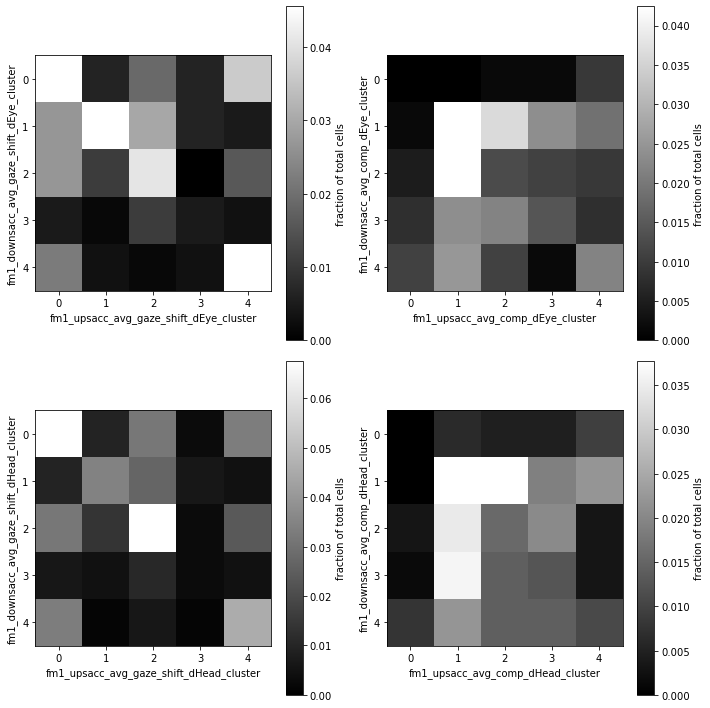

In [60]:
rec = 'fm1'
fig, axs = plt.subplots(2,2,figsize=(10,10))
axs=axs.ravel()
cnt=0
for eh in eye_head:
    for m,m_t in enumerate(mov_type):
        
        up_clust = 'fm1_upsacc_avg_%s_%s_cluster' % (m_t,eh)
        down_clust = 'fm1_downsacc_avg_%s_%s_cluster' % (m_t,eh)
        
        delta_array = np.zeros([5,5])
        for index,row in df.iterrows():
            up_ind = int(row[up_clust])
            down_ind = int(row[down_clust])
            delta_array[up_ind,down_ind] = delta_array[up_ind,down_ind] + 1
        delta_array /= len(df)
        
        da = delta_array.copy()
        idx = np.unravel_index(np.argmax(da), da.shape)
        da[idx[0],idx[1]]=0
        
        ax = axs[cnt]
        pos = ax.imshow(delta_array,cmap='gray',vmin=0,vmax=np.amax(da))
        ax.set_xlabel(up_clust)
        ax.set_ylabel(down_clust)
        cbar = plt.colorbar(pos,ax=ax)
        cbar.set_label('fraction of total cells')
        
        cnt+=1
fig.tight_layout()

In [81]:
df.shape

(636, 530)

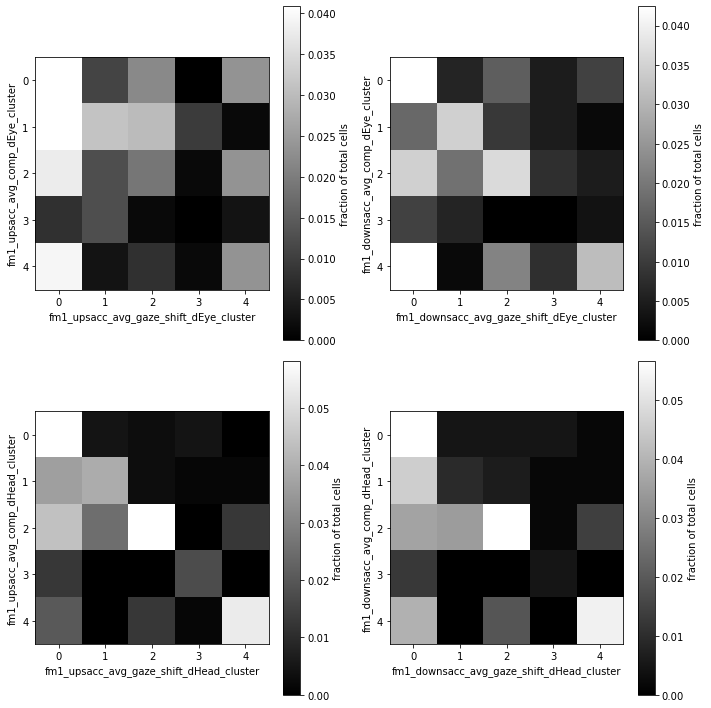

In [82]:
rec = 'fm1'
fig, axs = plt.subplots(2,2,figsize=(10,10))
axs=axs.ravel()
cnt=0
comp_remap = [3.,0.,2.,4.,1.]
for eh in eye_head:
    for s,sac in enumerate(sacs):
        
        up_clust = 'fm1_%s_avg_gaze_shift_%s_cluster' % (sac,eh)
        down_clust = 'fm1_%s_avg_comp_%s_cluster' % (sac,eh)
        
        
        comp_remap_type = []
        for index,row in df.iterrows():
            comp_remap_type.append(comp_remap[int(row[down_clust])])
            
        df['comp_remap_type'] = comp_remap_type
        
        delta_array = np.zeros([5,5])
        for index,row in df.iterrows():
            up_ind = int(row[up_clust])
            down_ind = int(row['comp_remap_type'])
            delta_array[up_ind,down_ind] = delta_array[up_ind,down_ind] + 1
        delta_array /= len(df)
        
        da = delta_array.copy()
        idx = np.unravel_index(np.argmax(da), da.shape)
        da[idx[0],idx[1]]=0
        
        ax = axs[cnt]
        pos = ax.imshow(delta_array,cmap='gray',vmin=0,vmax=np.amax(da))
        ax.set_xlabel(up_clust)
        ax.set_ylabel(down_clust)
        cbar = plt.colorbar(pos,ax=ax)
        cbar.set_label('fraction of total cells')
        
        cnt+=1
fig.tight_layout()

In [101]:
delta_array

array([[0.64779874, 0.00471698, 0.00471698, 0.00471698, 0.00157233],
       [0.04559748, 0.00943396, 0.00628931, 0.00157233, 0.00157233],
       [0.03616352, 0.03459119, 0.05660377, 0.00157233, 0.01415094],
       [0.01257862, 0.        , 0.        , 0.00471698, 0.        ],
       [0.03930818, 0.        , 0.01886792, 0.        , 0.05345912]])

In [76]:
up_clust = 'fm1_%s_avg_gaze_shift_%s_cluster_type' % (sac,eh)
down_clust = 'fm1_%s_avg_comp_%s_cluster_type' % (sac,eh)

In [77]:
np.unique(df[up_clust])

array(['biphasic', 'early', 'late', 'negative', 'unresponsive'],
      dtype=object)

In [ ]:
#gaze
#0 = unresponsive
#1 = biphasic
#2 = late
#3 = negative
#4 = early

#comp
#0 = negative
#1 = unresponsive
#2 = late
#3 = early
#4 = biphasic

comp_remap = [3,0,2,4,1]
comp_remap_type = []
for index,row in df.iterrows():
    comp_remap_type.append(comp_remap[row[down_clust]])

In [75]:
df.columns.values

array(['index', 'Amplitude', 'ContamPct', 'KSLabel', 'amp', 'ch', 'depth',
       'fr', 'group', 'fm1_n_spikes', 'sh', 'waveform', 'fm1_spikeT',
       't0', 'fm1_spikeTraw', 'fm1_rate', 'fm1_c_range', 'fm1_crf_cent',
       'fm1_crf_tuning', 'fm1_crf_err', 'fm1_spike_triggered_average',
       'fm1_sta_shape', 'fm1_spike_triggered_variance', 'fm1_upsacc_avg',
       'fm1_downsacc_avg', 'fm1_upsacc_avg_gaze_shift_dEye',
       'fm1_downsacc_avg_gaze_shift_dEye', 'fm1_upsacc_avg_comp_dEye',
       'fm1_downsacc_avg_comp_dEye', 'fm1_upsacc_avg_gaze_shift_dHead',
       'fm1_downsacc_avg_gaze_shift_dHead', 'fm1_upsacc_avg_comp_dHead',
       'fm1_downsacc_avg_comp_dHead',
       'fm1_spike_rate_vs_pupil_radius_cent',
       'fm1_spike_rate_vs_pupil_radius_tuning',
       'fm1_spike_rate_vs_pupil_radius_err',
       'fm1_spike_rate_vs_theta_cent', 'fm1_spike_rate_vs_theta_tuning',
       'fm1_spike_rate_vs_theta_err', 'fm1_spike_rate_vs_gz_cent',
       'fm1_spike_rate_vs_gz_tuning', 'fm1_